# Math 251 Classification Project

In [1]:
import math
import time
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import neighbors
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import lognorm


## 1. Preparation: Import & Check data

**Read in the csv file as a dataframe called data**

In [2]:
data = pd.read_csv('Smoking Drinking dataset.csv')

**Check the info() of the data**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991346 entries, 0 to 991345
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               991346 non-null  object 
 1   age               991346 non-null  int64  
 2   height            991346 non-null  int64  
 3   weight            991346 non-null  int64  
 4   waistline         991346 non-null  float64
 5   sight_left        991346 non-null  float64
 6   sight_right       991346 non-null  float64
 7   hear_left         991346 non-null  int64  
 8   hear_right        991346 non-null  int64  
 9   SBP               991346 non-null  int64  
 10  DBP               991346 non-null  int64  
 11  BLDS              991346 non-null  int64  
 12  tot_chole         991346 non-null  int64  
 13  HDL_chole         991346 non-null  int64  
 14  LDL_chole         991346 non-null  int64  
 15  triglyceride      991346 non-null  int64  
 16  hemoglobin        99

**Check the head of data**

In [4]:
data.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,35,170,75,90.0,1.0,1.0,1,1,120,...,126,92,17.1,1,1.0,21,35,40,1,Y
1,Male,30,180,80,89.0,0.9,1.2,1,1,130,...,148,121,15.8,1,0.9,20,36,27,3,N
2,Male,40,165,75,91.0,1.2,1.5,1,1,120,...,74,104,15.8,1,0.9,47,32,68,1,N
3,Male,50,175,80,91.0,1.5,1.2,1,1,145,...,104,106,17.6,1,1.1,29,34,18,1,N
4,Male,50,165,60,80.0,1.0,1.2,1,1,138,...,117,104,13.8,1,0.8,19,12,25,1,N


In [5]:
data.shape

(991346, 24)

**Check missing values**

In [6]:
data.isna().sum()

sex                 0
age                 0
height              0
weight              0
waistline           0
sight_left          0
sight_right         0
hear_left           0
hear_right          0
SBP                 0
DBP                 0
BLDS                0
tot_chole           0
HDL_chole           0
LDL_chole           0
triglyceride        0
hemoglobin          0
urine_protein       0
serum_creatinine    0
SGOT_AST            0
SGOT_ALT            0
gamma_GTP           0
SMK_stat_type_cd    0
DRK_YN              0
dtype: int64

In [7]:
data.nunique()

sex                    2
age                   14
height                13
weight                24
waistline            737
sight_left            24
sight_right           24
hear_left              2
hear_right             2
SBP                  171
DBP                  127
BLDS                 498
tot_chole            474
HDL_chole            223
LDL_chole            432
triglyceride        1657
hemoglobin           190
urine_protein          6
serum_creatinine     183
SGOT_AST             568
SGOT_ALT             594
gamma_GTP            940
SMK_stat_type_cd       3
DRK_YN                 2
dtype: int64

**Duplication**

In [8]:
# Check duplicated data points
data[data.duplicated()].shape

(26, 24)

In [9]:
# Remove duplications
data=data.drop_duplicates(keep='first')
data[data.duplicated()].shape

(0, 24)

In [10]:
# After remove duplications, there are 991,320 observations in totla.
data.shape

(991320, 24)

# 2. Variables & Data Cleaning

**(1) Variable name, value and generate reponse y**

**A.Change variable name**

In [11]:
data=data.rename({'SMK_stat_type_cd': 'smoker',"DRK_YN":'drinker'},axis='columns')

**B. Change Variable values**

**'sex': Female=1, Male=0**

**'drinker': Y=1, N=0**

**'hear_left' & 'hear_right': 2=0 (abornal)**

In [12]:
data.loc[data['sex']=='Female','sex']=1
data.loc[data['sex']=='Male','sex']=0
data['sex'] = data['sex'].astype('int')

data.loc[data['drinker']=='Y','drinker']=1
data.loc[data['drinker']=='N','drinker']=0

data.loc[data['hear_left']==2,'hear_left']=0
data.loc[data['hear_right']==2,'hear_right']=0

**C.Generate Response smoker_drinker**

smoker=1/2 (never/quit), drinker=no 0, smoker_drinker=0 (not smaker, not drinker)

smoker=3 (smoker), drinker=no 0, smoker_drinker=1 (smoker, not drinker)

smoker=1/2, drinker=yes 1, smoker_drinker=2 (not smoker, drinker)

smoker=3, drinker=yes 1, smoker_drinker=3 (smoker and drinker)

In [13]:
data['smoker_drinker']=0

data.loc[(data['smoker']==1) & (data['drinker']==0),'smoker_drinker']=0
data.loc[((data['smoker']==2) | (data['smoker']==3)) & (data['drinker']==0),'smoker_drinker']=1
data.loc[(data['smoker']==1) & (data['drinker']==1),'smoker_drinker']=2
data.loc[((data['smoker']==2) | (data['smoker']==3)) & (data['drinker']==1),'smoker_drinker']=3

np.unique(data['smoker_drinker'])

array([0, 1, 2, 3])

In [14]:
# change smoker's value from 1,2,3 to 0,1,2
data.loc[data['smoker']==1,'smoker']=0
data.loc[data['smoker']==2,'smoker']=1
data.loc[data['smoker']==3,'smoker']=2

**Change this value to select different Y. 3 options: 'drinker', 'smoker', 'smoker_drinker'**

In [15]:
Ynames = ['drinker', 'smoker', 'smoker_drinker']
Y_levels = {'drinker':['No Drink', 'Drink'],
            'smoker': ['Never Smoke', 'Previously Smoke', 'Active Smoke'],
            'smoker_drinker': ['No Smoke & No Drink', 'Smoke but No Drink', 'No Smoke but Drink', 'Smoke & Drink']}
Y_col_name = Ynames[1]
Y_class_num = int(data[Y_col_name].max()+1)

In [16]:
# Distribution of each category of y
data[Y_col_name].value_counts(normalize=True)

0    0.607706
2    0.215818
1    0.176476
Name: smoker, dtype: float64

In [17]:
# Drop 'urine_protein' and unused Y variables. Won't use them in the following
data=data.drop(['urine_protein'],axis=1)

**(2) Summary of variables**

In [18]:
# Summary of X
data[['age', 'height','weight', 'waistline', 'sight_left', 'sight_right', 'SBP', 'DBP','BLDS','tot_chole','HDL_chole',
         'LDL_chole','triglyceride', 'hemoglobin','serum_creatinine','SGOT_AST','SGOT_ALT','gamma_GTP']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,991320.0,47.614529,14.181346,20.0,35.0,45.0,60.0,85.0
height,991320.0,162.240563,9.282922,130.0,155.0,160.0,170.0,190.0
weight,991320.0,63.283884,12.514101,25.0,55.0,60.0,70.0,140.0
waistline,991320.0,81.233255,11.850296,8.0,74.1,81.0,87.8,999.0
sight_left,991320.0,0.980833,0.605954,0.1,0.7,1.0,1.2,9.9
sight_right,991320.0,0.978428,0.604779,0.1,0.7,1.0,1.2,9.9
SBP,991320.0,122.432360,14.543083,67.0,112.0,120.0,131.0,273.0
DBP,991320.0,76.052549,9.889334,32.0,70.0,76.0,82.0,185.0
BLDS,991320.0,100.424305,24.179852,25.0,88.0,96.0,105.0,852.0
tot_chole,991320.0,195.556769,38.660092,30.0,169.0,193.0,219.0,2344.0


**(3) Abnormal values**

In [19]:
# eye sight: 9.9 means blind, so gives it 0 value.
data.loc[data['sight_left']==9.9, 'sight_left']=0
data.loc[data['sight_right']==9.9, 'sight_right']=0

In [20]:
# Remove observations in which waistline==999
data = data[data['waistline'] !=999]
data.shape

(991263, 24)

In [21]:
# There are 991,263 observations in total
data = data.reset_index(drop=True)
data_conts = data[['age', 'height','weight', 'waistline', 'sight_left', 'sight_right', 'SBP', 'DBP','BLDS','tot_chole','HDL_chole',
         'LDL_chole','triglyceride', 'hemoglobin','serum_creatinine','SGOT_AST','SGOT_ALT','gamma_GTP']]
data_conts.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,991263.0,47.615552,14.181086,20.0,35.0,45.0,60.0,85.0
height,991263.0,162.240687,9.283100,130.0,155.0,160.0,170.0,190.0
weight,991263.0,63.283997,12.514296,25.0,55.0,60.0,70.0,140.0
waistline,991263.0,81.180481,9.591700,8.0,74.1,81.0,87.8,149.1
sight_left,991263.0,0.949688,0.344997,0.0,0.7,1.0,1.2,2.5
sight_right,991263.0,0.947355,0.343527,0.0,0.7,1.0,1.2,2.5
SBP,991263.0,122.433242,14.542873,67.0,112.0,120.0,131.0,273.0
DBP,991263.0,76.053114,9.889155,32.0,70.0,76.0,82.0,185.0
BLDS,991263.0,100.425394,24.180038,25.0,88.0,96.0,105.0,852.0
tot_chole,991263.0,195.554860,38.658738,30.0,169.0,193.0,219.0,2344.0


In [22]:
data.tail()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,smoker,drinker,smoker_drinker
991258,0,45,175,80,92.1,1.5,1.5,1,1,114,...,125,132,15.0,1.0,26,36,27,0,0,0
991259,0,35,170,75,86.0,1.0,1.5,1,1,119,...,84,45,15.8,1.1,14,17,15,0,0,0
991260,1,40,155,50,68.0,1.0,0.7,1,1,110,...,77,157,14.3,0.8,30,27,17,2,1,3
991261,0,25,175,60,72.0,1.5,1.0,1,1,119,...,73,53,14.5,0.8,21,14,17,0,0,0
991262,0,50,160,70,90.5,1.0,1.5,1,1,133,...,153,163,15.8,0.9,24,43,36,2,1,3


In [23]:
data_conts.shape

(991263, 18)

## 3. Standardization/Normalization

In [24]:
# Standardization of X
scaler = StandardScaler()
scaler.fit(data_conts)
scaled_features = scaler.transform(data_conts)

In [25]:
data_X = pd.DataFrame(scaled_features,columns=data_conts.columns)
data_X = pd.concat([data_X, data[['sex', 'hear_left', 'hear_right']]], axis=1)
data_X.head()

,age,height,weight,waistline,sight_left,sight_right,SBP,DBP,BLDS,tot_chole,...,LDL_chole,triglyceride,hemoglobin,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,sex,hear_left,hear_right
0,-0.889605,0.835854,0.936210,0.919495,0.145834,0.153250,-0.167315,0.399113,-0.058949,-0.066088,...,0.361651,-0.392753,1.810919,0.290333,-0.212391,0.351362,0.056765,0,1,1
1,-1.242187,1.913081,1.335753,0.815238,-0.144024,0.735446,0.520307,0.601355,0.230546,0.839271,...,0.975435,-0.108982,0.990663,0.082235,-0.254954,0.389371,-0.201044,0,1,1
2,-0.537022,0.297241,0.936210,1.023752,0.725550,1.608740,-0.167315,-0.612097,-0.100306,-1.540529,...,-1.089111,-0.275331,0.990663,0.082235,0.894266,0.237334,0.612047,0,1,1
3,0.168143,1.374468,1.335753,1.023752,1.595124,0.735446,1.551741,1.106959,-0.224375,0.140852,...,-0.252133,-0.255760,2.126403,0.498430,0.128119,0.313353,-0.379527,0,1,1
4,0.168143,0.297241,-0.262420,-0.123073,0.145834,0.735446,1.070405,0.601355,0.023764,0.089117,...,0.110558,-0.275331,-0.271270,-0.125863,-0.297518,-0.522850,-0.240707,0,1,1


In [26]:
data_y = data[Y_col_name]

In [27]:
data = pd.concat([data_X, data_y], axis=1)
data[Y_col_name] = data[Y_col_name].astype('int64')
data

,age,height,weight,waistline,sight_left,sight_right,SBP,DBP,BLDS,tot_chole,...,triglyceride,hemoglobin,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,sex,hear_left,hear_right,smoker
0,-0.889605,0.835854,0.936210,0.919495,0.145834,0.153250,-0.167315,0.399113,-0.058949,-0.066088,...,-0.392753,1.810919,0.290333,-0.212391,0.351362,0.056765,0,1,1,0
1,-1.242187,1.913081,1.335753,0.815238,-0.144024,0.735446,0.520307,0.601355,0.230546,0.839271,...,-0.108982,0.990663,0.082235,-0.254954,0.389371,-0.201044,0,1,1,2
2,-0.537022,0.297241,0.936210,1.023752,0.725550,1.608740,-0.167315,-0.612097,-0.100306,-1.540529,...,-0.275331,0.990663,0.082235,0.894266,0.237334,0.612047,0,1,1,0
3,0.168143,1.374468,1.335753,1.023752,1.595124,0.735446,1.551741,1.106959,-0.224375,0.140852,...,-0.255760,2.126403,0.498430,0.128119,0.313353,-0.379527,0,1,1,0
4,0.168143,0.297241,-0.262420,-0.123073,0.145834,0.735446,1.070405,0.601355,0.023764,0.089117,...,-0.275331,-0.271270,-0.125863,-0.297518,-0.522850,-0.240707,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991258,-0.184440,1.374468,1.335753,1.138435,1.595124,1.608740,-0.579889,0.399113,-0.513870,0.063249,...,-0.001345,0.485890,0.290333,0.000428,0.389371,-0.201044,0,1,1,0
991259,-0.889605,0.835854,0.936210,0.502468,0.145834,1.608740,-0.236077,0.702476,-0.720652,-1.618131,...,-0.852658,0.990663,0.498430,-0.510336,-0.332804,-0.439022,0,1,1,0
991260,-0.537022,-0.779986,-1.061506,-1.374156,0.145834,-0.720044,-0.854938,-0.612097,-0.431157,0.244321,...,0.243285,0.044213,-0.125863,0.170683,0.047288,-0.399359,1,1,1,2
991261,-1.594770,1.374468,-0.262420,-0.957128,1.595124,0.153250,-0.236077,-0.207613,-1.299643,-1.902672,...,-0.774377,0.170406,-0.125863,-0.212391,-0.446832,-0.399359,0,1,1,0


In [28]:
data.head()

,age,height,weight,waistline,sight_left,sight_right,SBP,DBP,BLDS,tot_chole,...,triglyceride,hemoglobin,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,sex,hear_left,hear_right,smoker
0,-0.889605,0.835854,0.936210,0.919495,0.145834,0.153250,-0.167315,0.399113,-0.058949,-0.066088,...,-0.392753,1.810919,0.290333,-0.212391,0.351362,0.056765,0,1,1,0
1,-1.242187,1.913081,1.335753,0.815238,-0.144024,0.735446,0.520307,0.601355,0.230546,0.839271,...,-0.108982,0.990663,0.082235,-0.254954,0.389371,-0.201044,0,1,1,2
2,-0.537022,0.297241,0.936210,1.023752,0.725550,1.608740,-0.167315,-0.612097,-0.100306,-1.540529,...,-0.275331,0.990663,0.082235,0.894266,0.237334,0.612047,0,1,1,0
3,0.168143,1.374468,1.335753,1.023752,1.595124,0.735446,1.551741,1.106959,-0.224375,0.140852,...,-0.255760,2.126403,0.498430,0.128119,0.313353,-0.379527,0,1,1,0
4,0.168143,0.297241,-0.262420,-0.123073,0.145834,0.735446,1.070405,0.601355,0.023764,0.089117,...,-0.275331,-0.271270,-0.125863,-0.297518,-0.522850,-0.240707,0,1,1,0


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991263 entries, 0 to 991262
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   age               991263 non-null  float64
 1   height            991263 non-null  float64
 2   weight            991263 non-null  float64
 3   waistline         991263 non-null  float64
 4   sight_left        991263 non-null  float64
 5   sight_right       991263 non-null  float64
 6   SBP               991263 non-null  float64
 7   DBP               991263 non-null  float64
 8   BLDS              991263 non-null  float64
 9   tot_chole         991263 non-null  float64
 10  HDL_chole         991263 non-null  float64
 11  LDL_chole         991263 non-null  float64
 12  triglyceride      991263 non-null  float64
 13  hemoglobin        991263 non-null  float64
 14  serum_creatinine  991263 non-null  float64
 15  SGOT_AST          991263 non-null  float64
 16  SGOT_ALT          99

## 4. EDA

**(1) Response Variable**

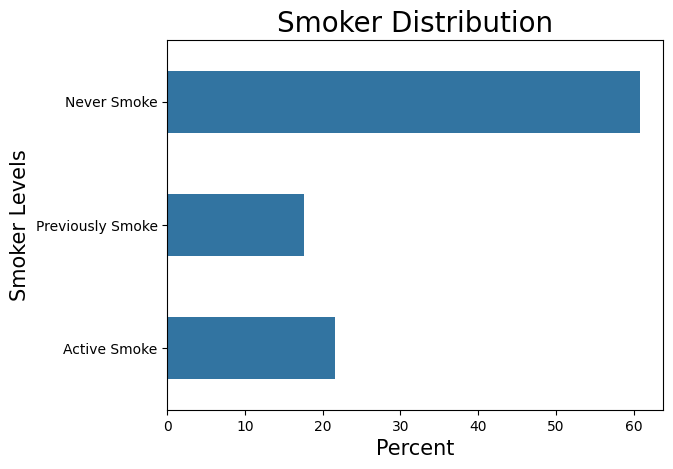

In [30]:
y_plot = sns.countplot(y=Y_col_name, stat='percent', data=data, width=0.5)
y_plot.set_xlabel('Percent', fontsize=15)
y_plot.set_ylabel('Smoker Levels', fontsize=15)
y_plot.set_title('Smoker Distribution', fontsize=20)
y_plot.set_yticks(y_plot.get_yticks())
y_plot.set_yticklabels(Y_levels[Y_col_name])

plt.show()

**(2) Pairwise Correlation: quantitative**

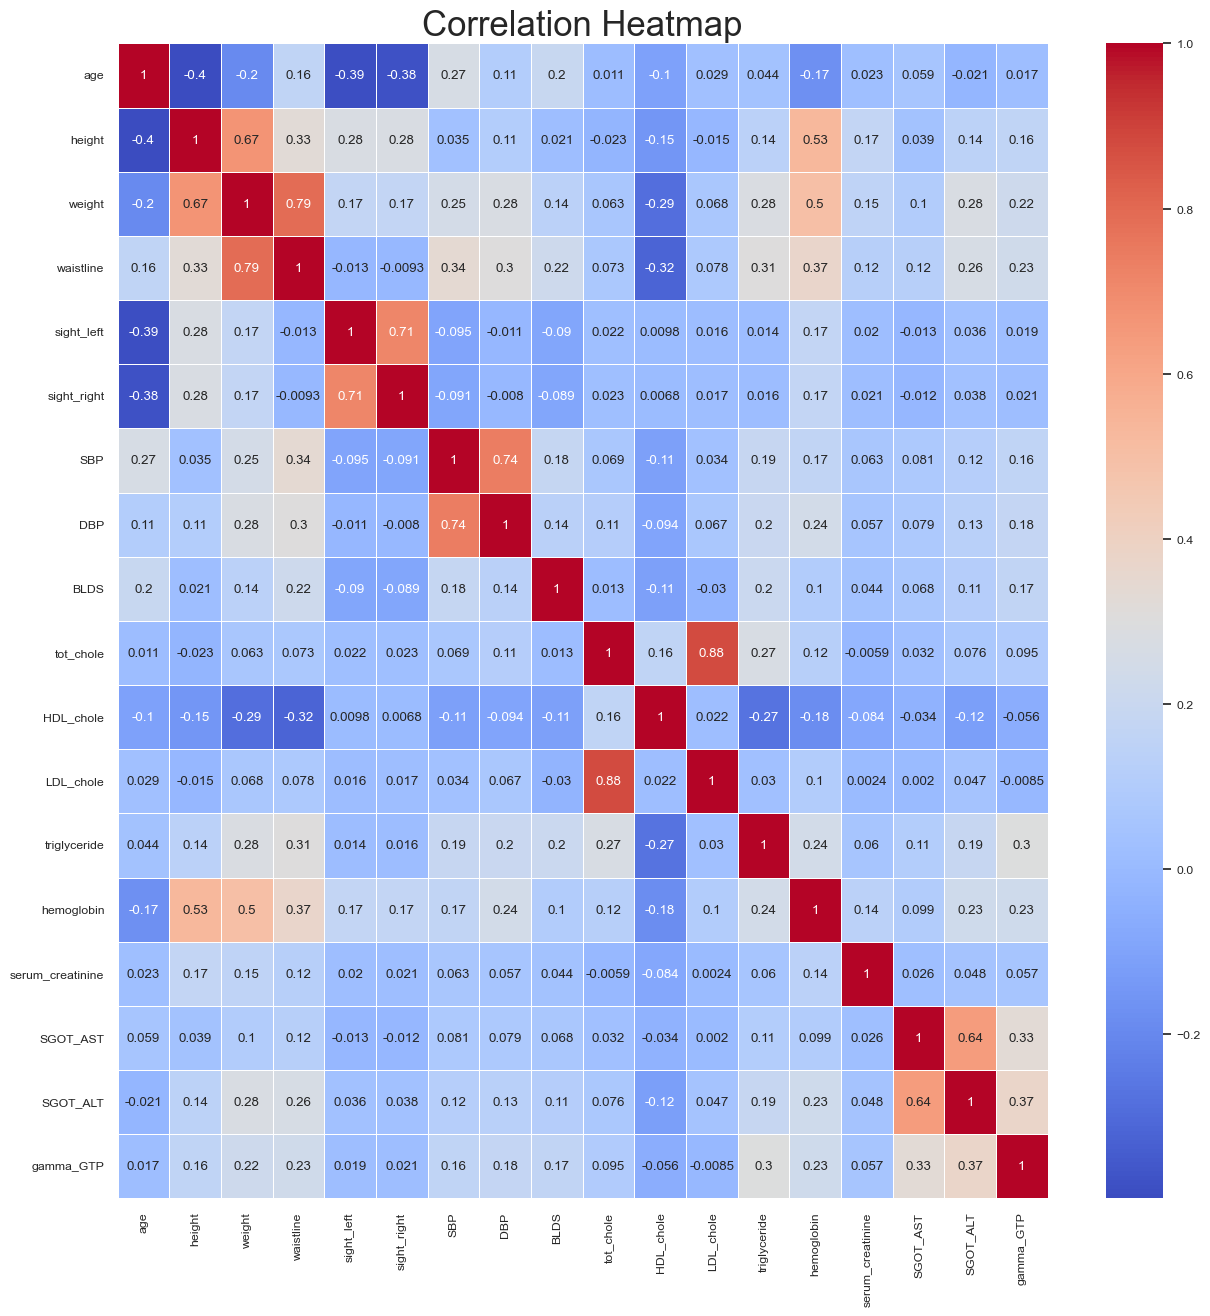

In [31]:
data2=data.copy()
data2=data2.drop(columns=['sex', 'hear_left', 'hear_right', Y_col_name])

corr_matrix = data2.corr()

plt.figure(figsize = (15,15))
sns.set(font_scale=0.8)
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm',linewidths=0.5)
plt.title('Correlation Heatmap',fontsize = 25)

plt.show()

**(3) Normality Test: quantitative**

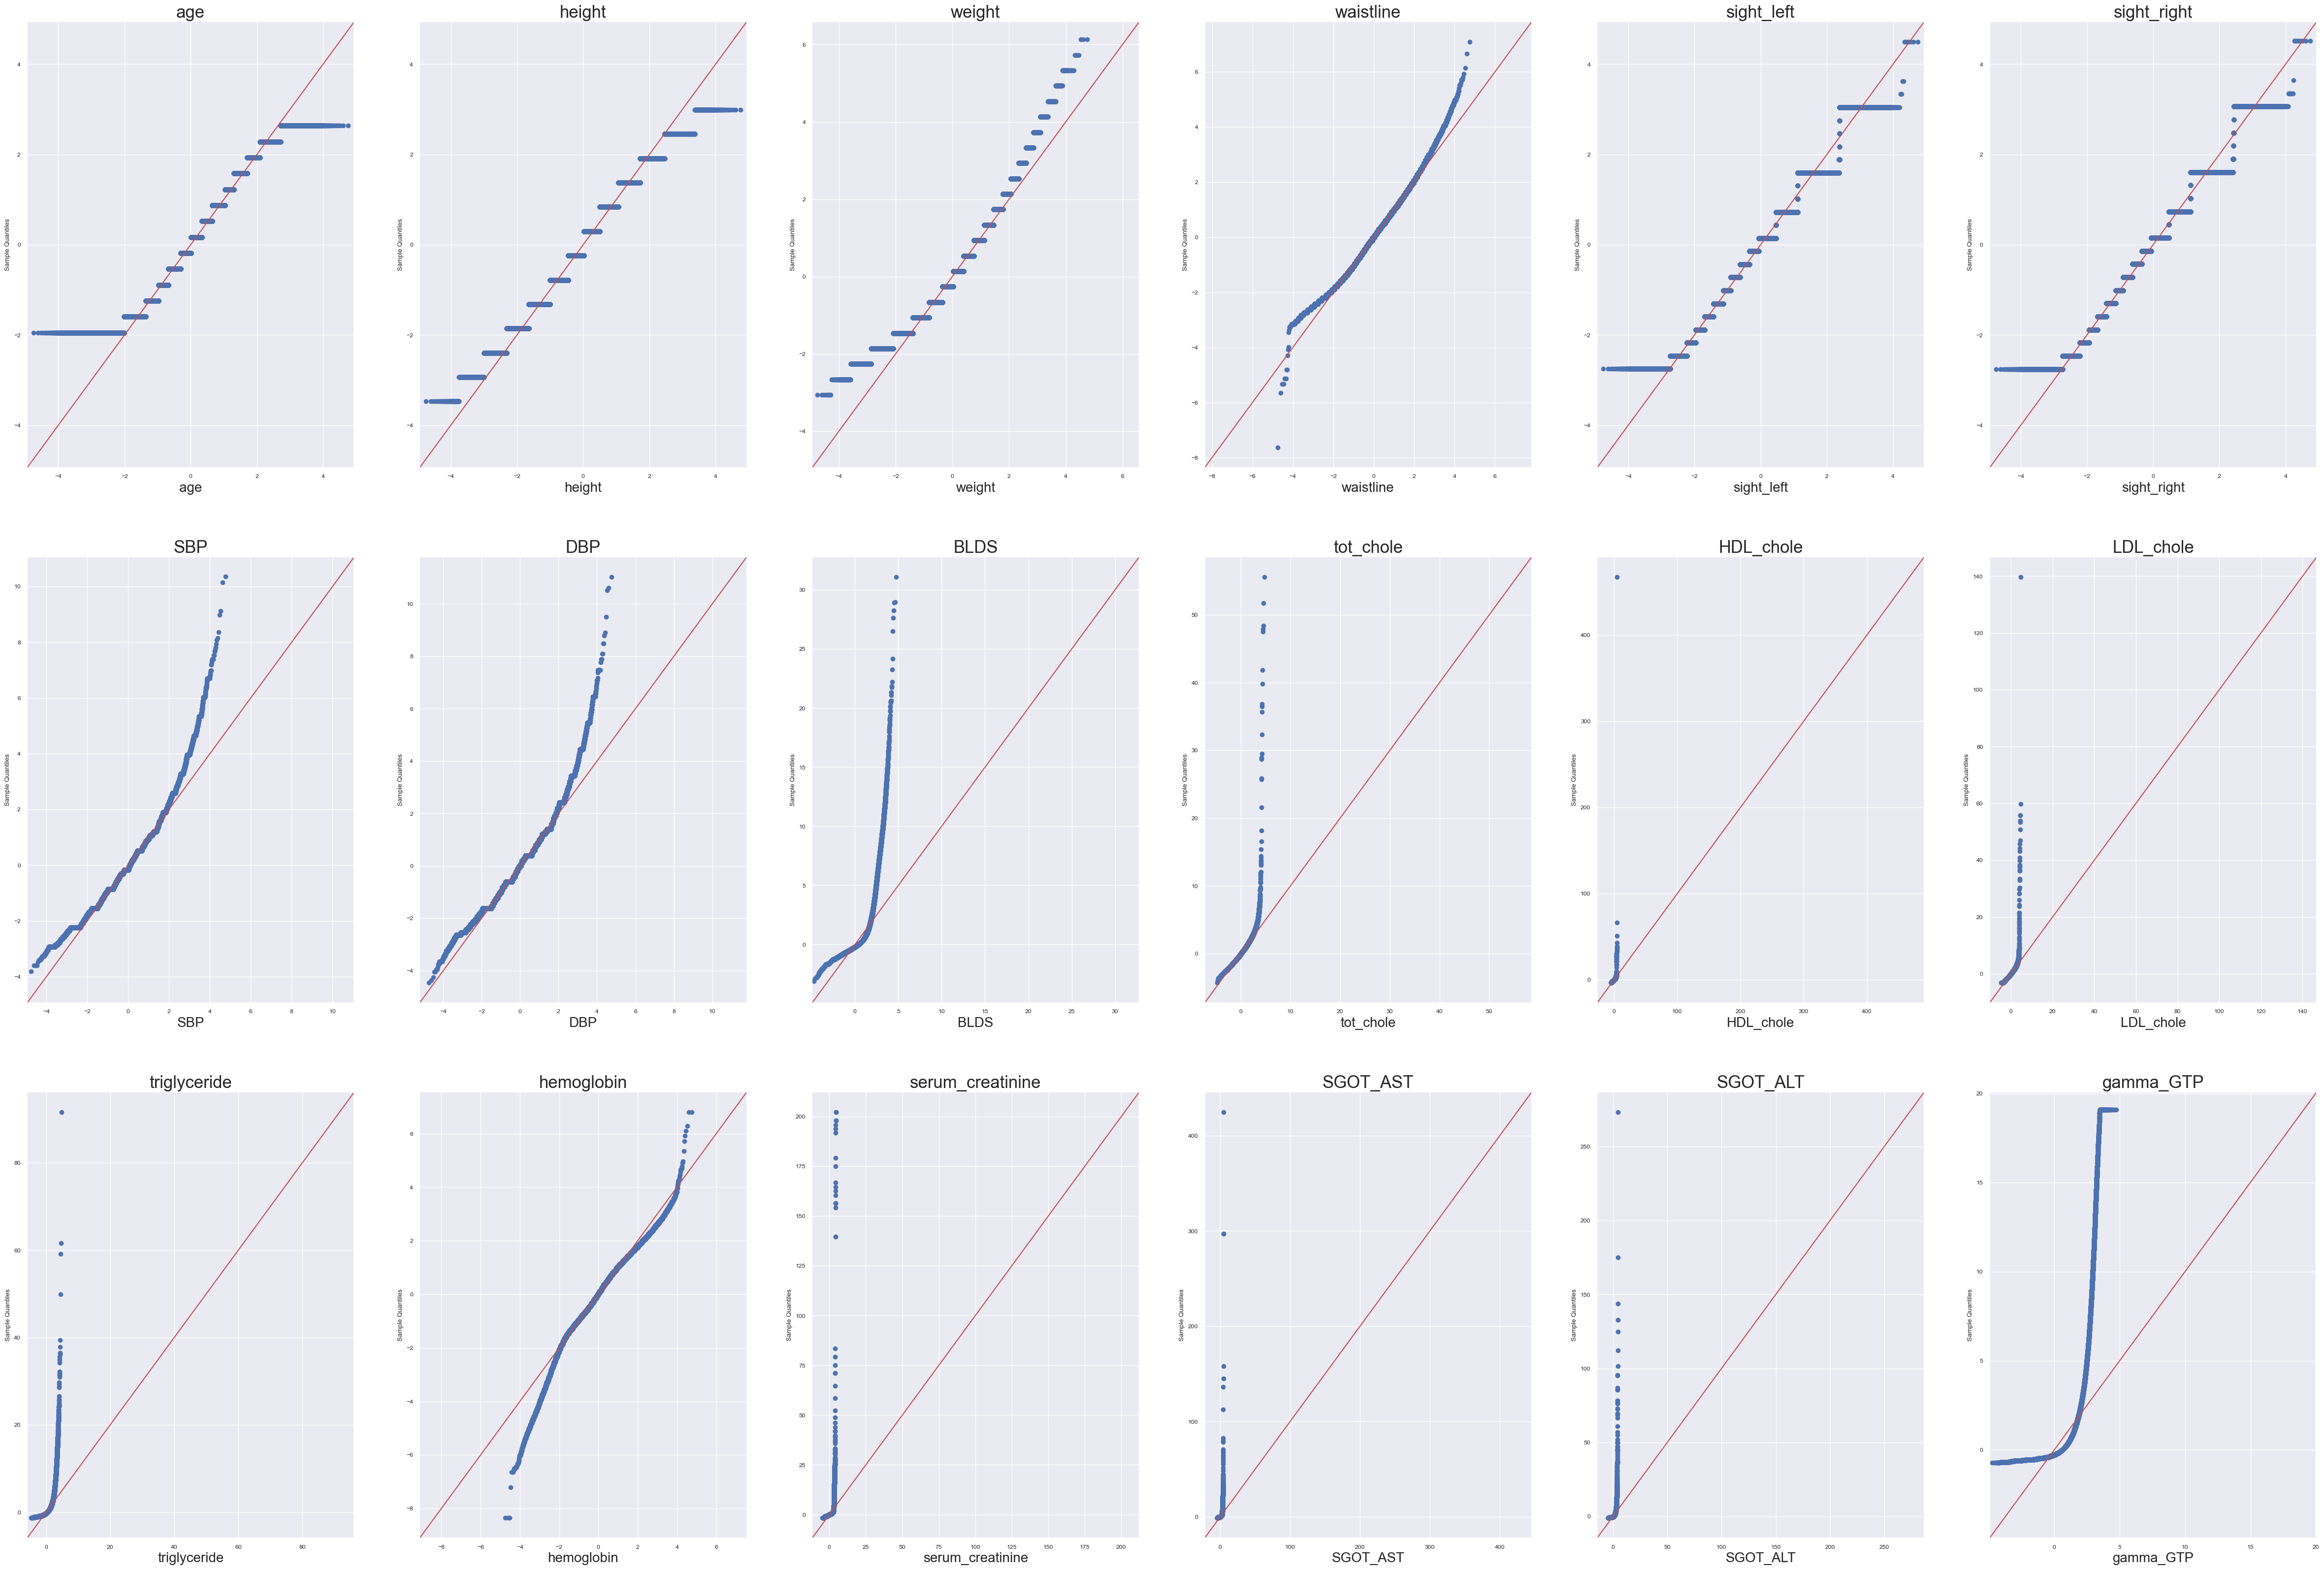

In [32]:
fig, ax =plt.subplots(nrows=3,ncols=6,figsize =(60,40))

columns = ['age', 'height', 'weight', 'waistline', 'sight_left', 'sight_right','SBP', 'DBP', 'BLDS', 'tot_chole',
       'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP']

#create Q-Q plot with 45-degree line added to plot

for r in range(3):
    for c in range(6):
        idx = r * 6 + c
        sm.qqplot(data[columns[idx]], line='45',ax=ax[r,c])
        ax[r,c].set_xlabel(columns[idx], fontsize=20)
        ax[r,c].set_title(columns[idx], fontsize=25)

plt.show()

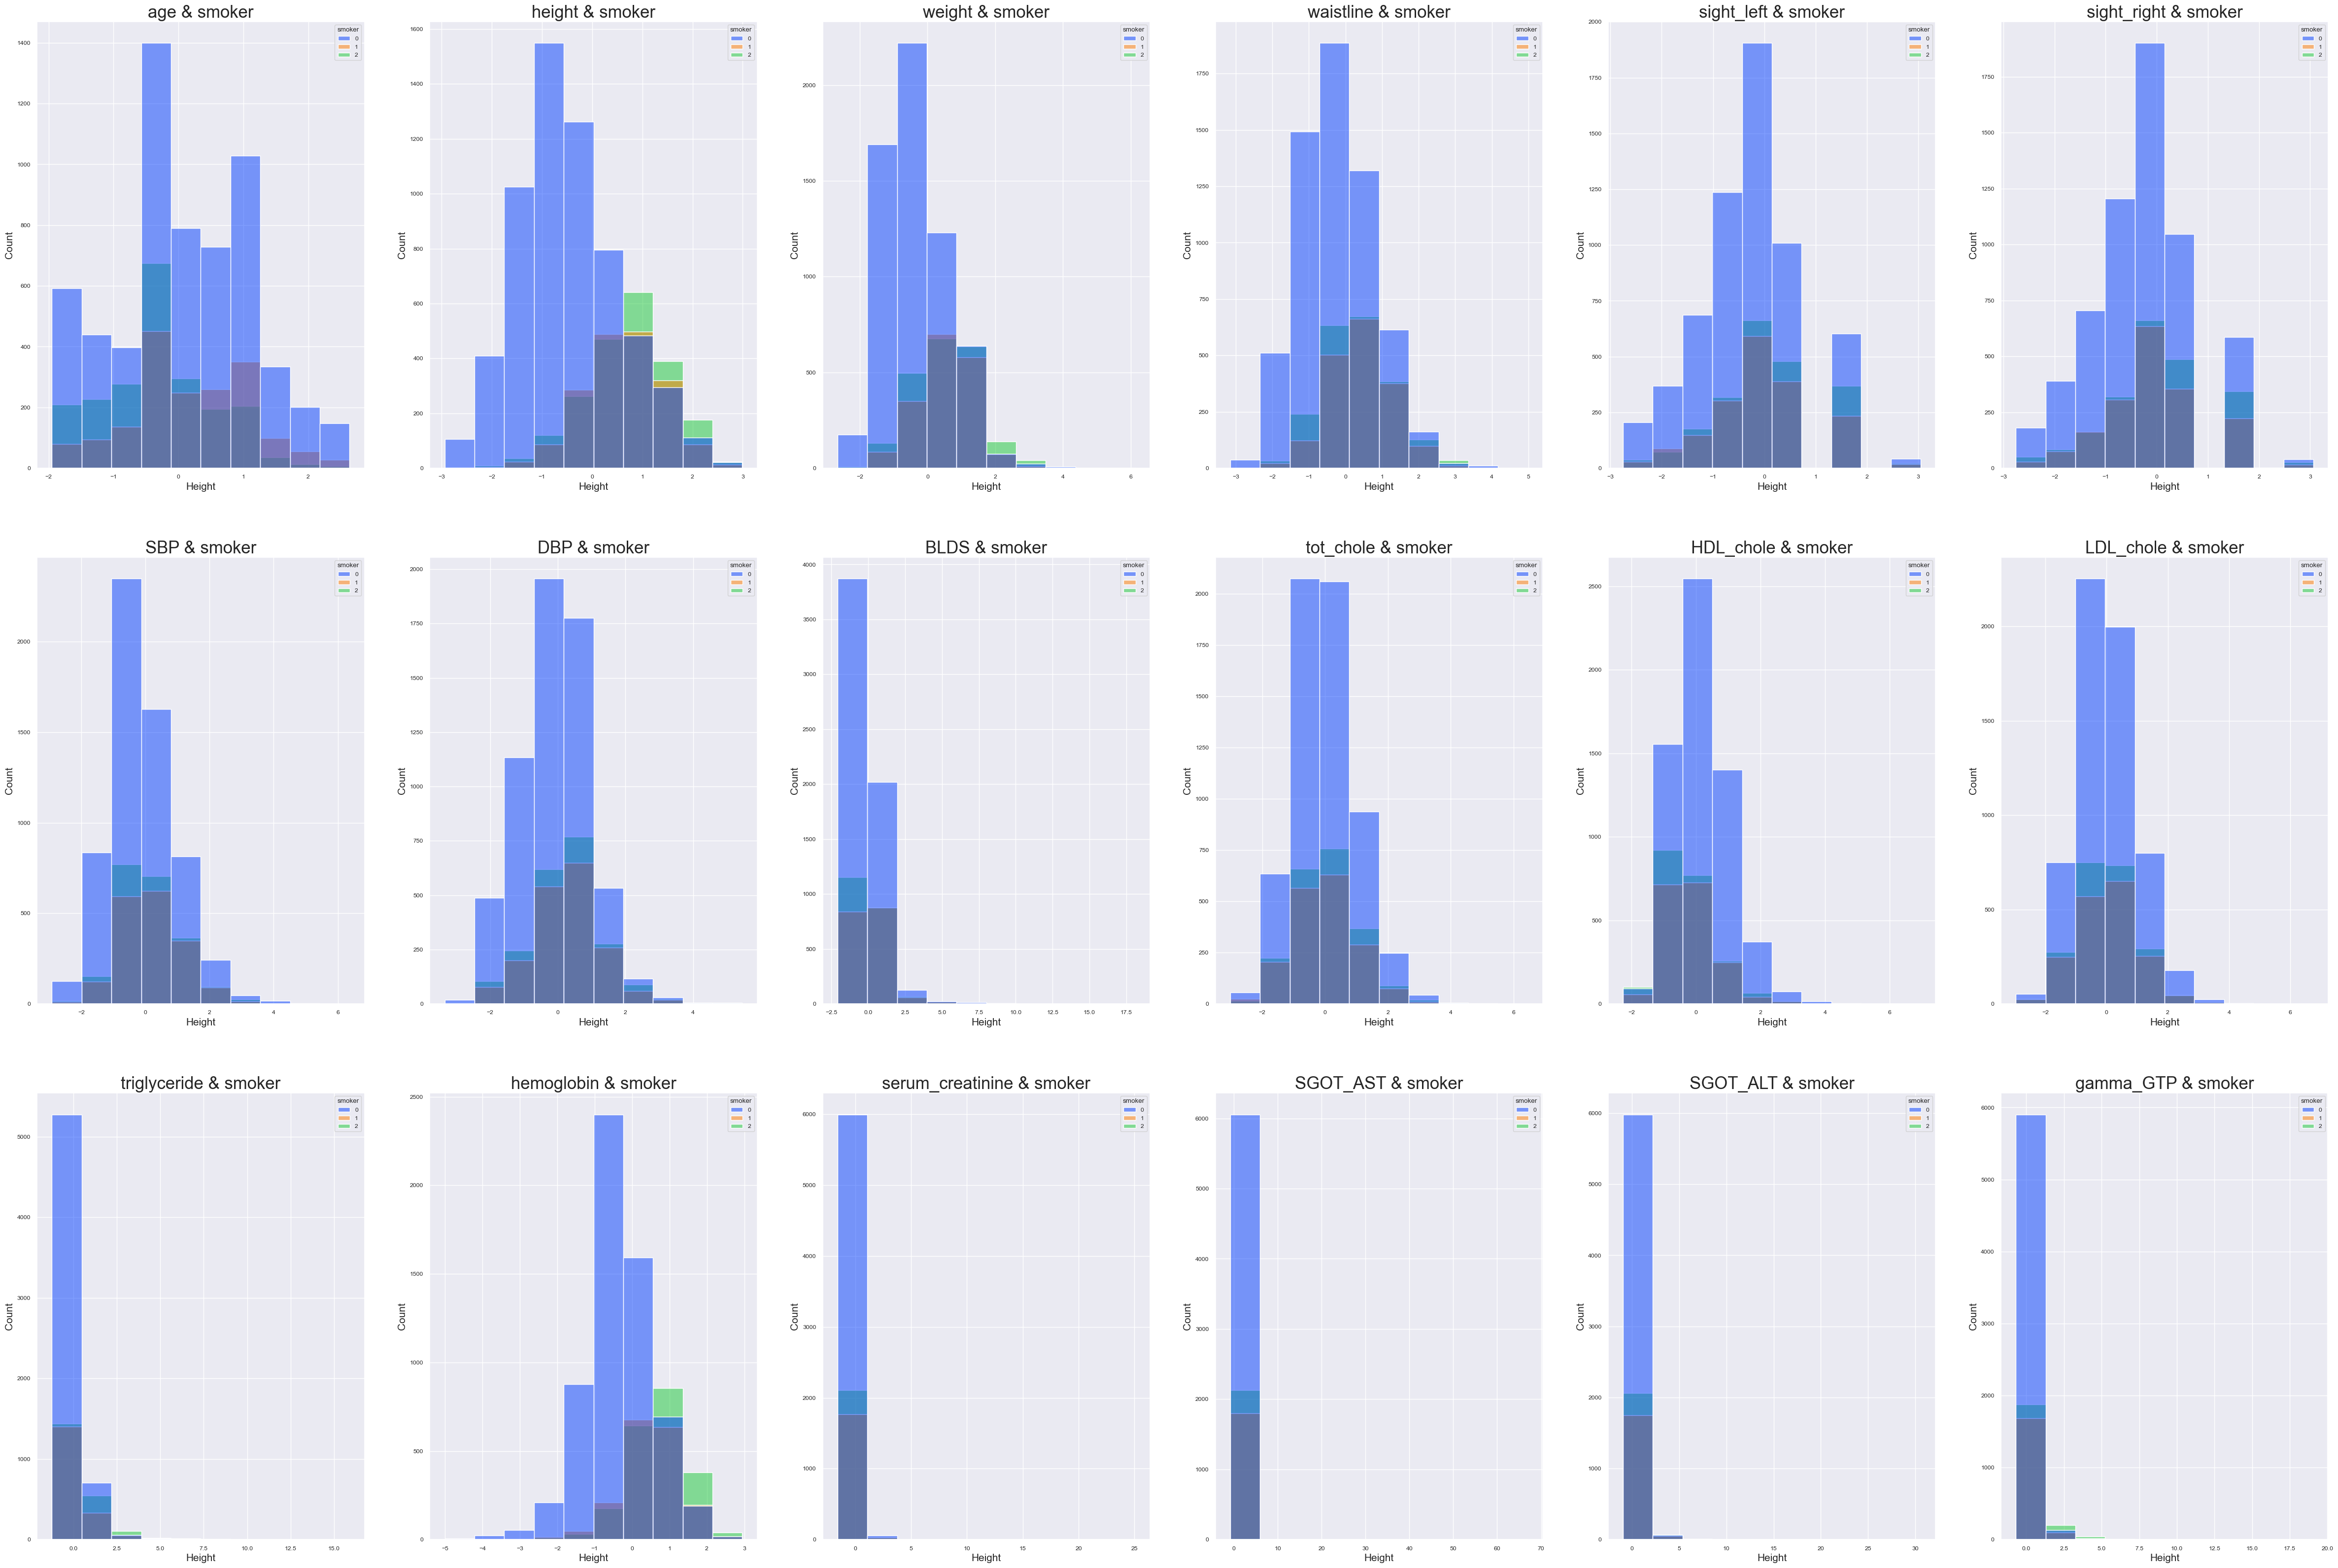

In [33]:
fig, ax =plt.subplots(nrows=3,ncols=6,figsize =(60,40))
plot_sample = data.sample(10000, random_state=1)
for r in range(3):
    for c in range(6):
        idx = r * 6 + c
        a = sns.histplot(data=plot_sample, x=columns[idx], hue=Y_col_name, bins=10, palette='bright',ax=ax[r,c])
        a.set_title(columns[idx]+' & '+Y_col_name, fontsize=25)
        a.set_ylabel('Count', fontsize=15)
        a.set_xlabel('Height', fontsize=15)

plt.show()

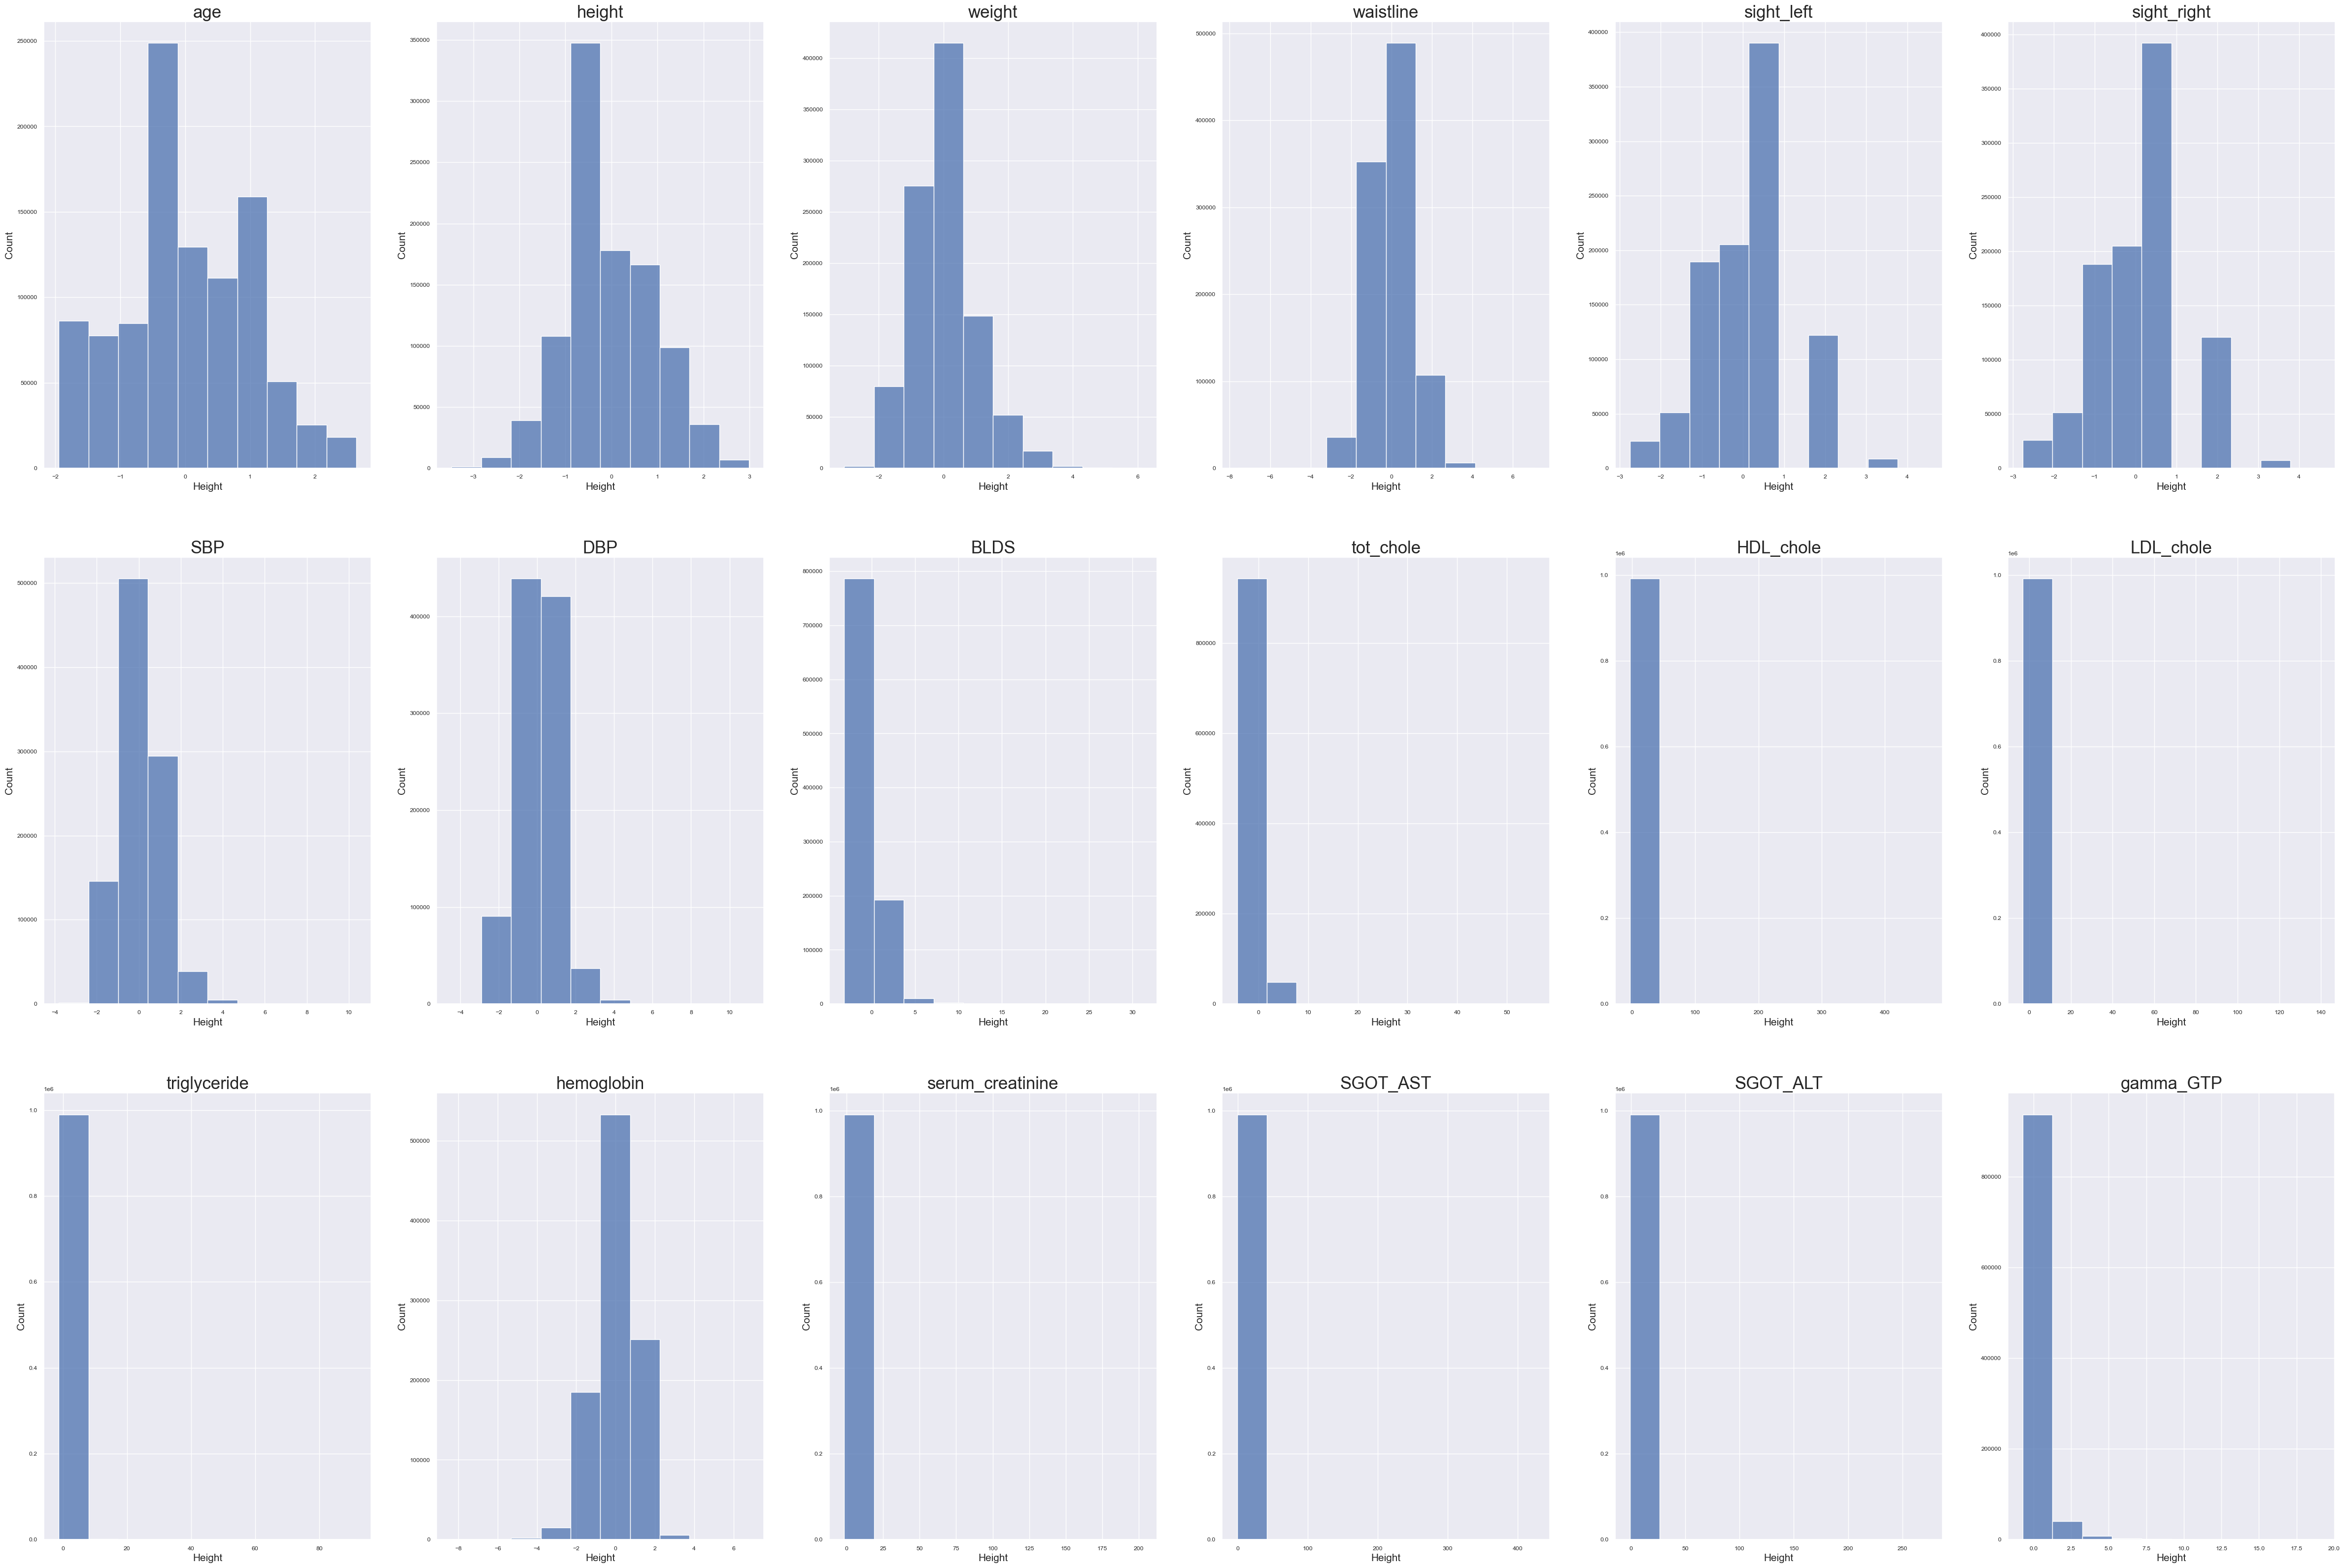

In [34]:
fig, ax =plt.subplots(nrows=3,ncols=6,figsize =(60,40))
plot_sample = data.sample(10000, random_state=1)
for r in range(3):
    for c in range(6):
        idx = r * 6 + c
        a = sns.histplot(data=data, x=columns[idx], bins=10, ax=ax[r,c])
        a.set_title(columns[idx], fontsize=25)
        a.set_ylabel('Count', fontsize=15)                                                                                                                                                                                 
        a.set_xlabel('Height', fontsize=15)

plt.show()

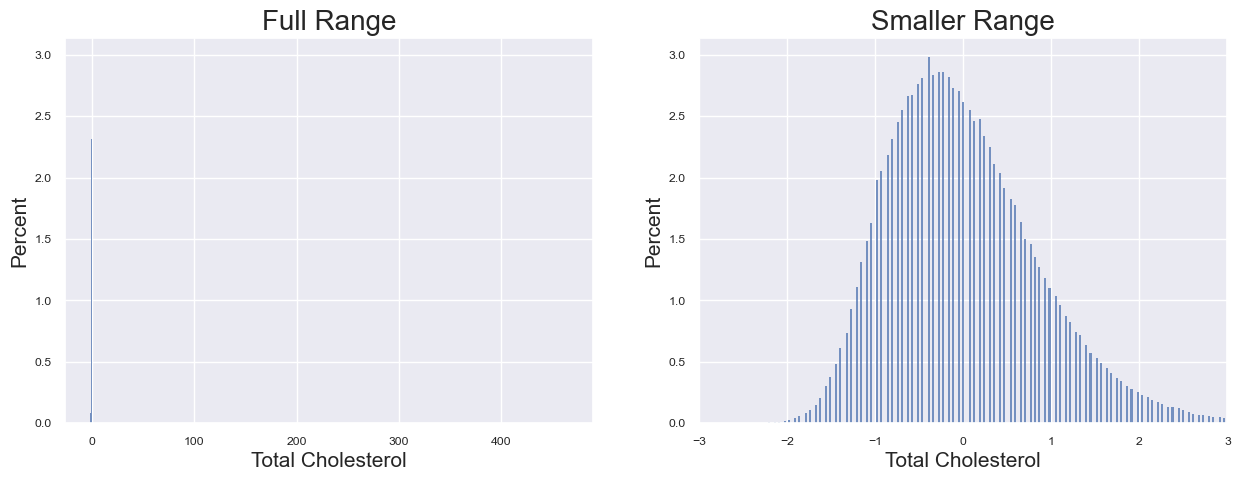

In [35]:
fig, ax =plt.subplots(nrows=1,ncols=2,figsize =(15,5))
original=sns.histplot(data=data,x='HDL_chole',stat='percent', ax=ax[0])
original.set_ylabel('Percent', fontsize=15)
original.set_xlabel('Total Cholesterol', fontsize=15)
original.set_title('Full Range', fontsize=20)

trim=sns.histplot(data=data,x='HDL_chole',stat='percent',ax=ax[1])
trim.set_ylabel('Percent', fontsize=15)
trim.set_xlabel('Total Cholesterol', fontsize=15)
# Restrict x-range to the major range: mean ± 3 * std
trim.set_xlim(left=data['HDL_chole'].mean() - 3 * data['HDL_chole'].std(),
              right=data['HDL_chole'].mean() + 3 * data['HDL_chole'].std())
trim.set_title('Smaller Range', fontsize=20)
plt.show()

In [36]:
data['HDL_chole'].mean() - 3 * data['HDL_chole'].std()

-3.000001513222157

**(4)Qualitative**

In [37]:
data['sex'].groupby(data['sex']).count()

sex
0    526399
1    464864
Name: sex, dtype: int64

In [38]:
data['hear_left'].groupby(data['hear_left']).count()

hear_left
0     31222
1    960041
Name: hear_left, dtype: int64

In [39]:
data['hear_right'].groupby(data['hear_right']).count()

hear_right
0     30211
1    961052
Name: hear_right, dtype: int64

## 5. Sample and Split: 1st Trial

**Sample 1: random sample 10k observations as training set; random sample 50 test sets, each of which has 1,000 observations**

In [125]:
# Set seed to make the results reproducible
np.random.seed(1000)

# Get index for 10,000 training data points out of 991,263 observations
training_index = np.random.choice(range(991263), 10000)

In [126]:
# Sample the training data set to contain 10,000 observations for faster propotype
training = data.iloc[training_index]
X_train = training.iloc[:,0:-1]
y_train = training[Y_col_name]

In [127]:
# Randomly sample 50 test data sets from the rest 990,263 observations. Each contains 1,000 observations
test_pool = data.drop(index=training_index)
X_test = [None]*50
y_test = [None]*50

for i in range(50):
    testdata=test_pool.sample(n=1000, random_state=i)
    X_test[i] = testdata.iloc[:,0:-1]
    y_test[i] = testdata[Y_col_name]

In [128]:
y_train.groupby(y_train).count()

smoker
0    6095
1    1735
2    2170
Name: smoker, dtype: int64

## 6. Fit Classification Models: Sample Data 1

## (1) KNN

In [129]:
parameters = {'n_neighbors': [1, 5, 10, 50, 100, 500, 1000],
              'weights': ['uniform', 'distance']}

knngs = GridSearchCV(neighbors.KNeighborsClassifier(), parameters, cv=10,
                     scoring='accuracy', return_train_score=False,verbose=1,error_score='raise')

# fitting the model for grid search
knngs.fit(X_train, y_train)
knngs.best_params_

Fitting 10 folds for each of 14 candidates, totalling 140 fits


{'n_neighbors': 50, 'weights': 'distance'}

<Axes: >

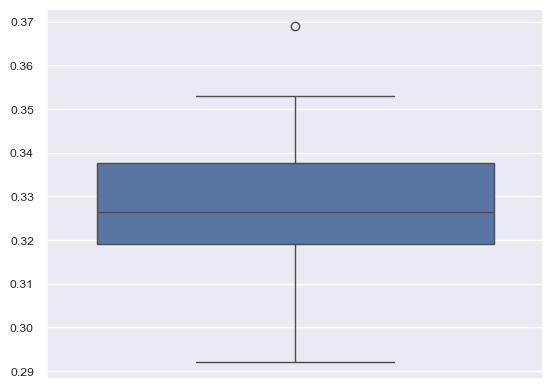

In [130]:
knngs_prediction=[None]*50
knngs_test_err=[None]*50

for i in range(50):
    knngs_prediction[i] = knngs.predict(X_test[i])
    knngs_test_err[i] = sum(y_test[i]!=knngs_prediction[i])/len(X_test[i])
sns.boxplot(knngs_test_err)

In [131]:
knngs_test_err = pd.DataFrame(knngs_test_err, columns = ['Test Error'])
model=['KNNGS']*50
knngs_test_err['Model']=model
knngs_test_err.head()

,Test Error,Model
0,0.325,KNNGS
1,0.337,KNNGS
2,0.314,KNNGS
3,0.313,KNNGS
4,0.326,KNNGS


## (2) Logistic Regression

In [132]:
lr = LogisticRegression(penalty='l2',max_iter=200,solver='newton-cg')
lr.fit(X_train,y_train)

LogisticRegression(max_iter=200, solver='newton-cg')

<Axes: >

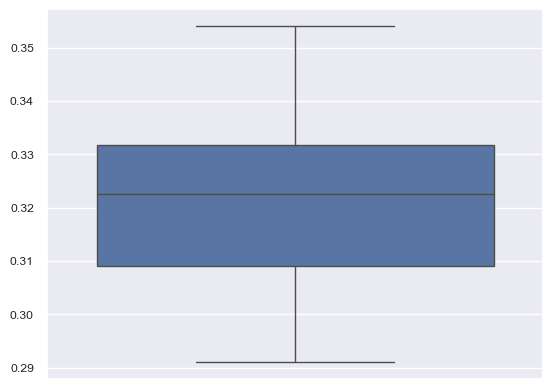

In [133]:
lr_prediction=[None]*50
lr_test_err=[None]*50

for i in range(50):
    lr_prediction[i] = lr.predict(X_test[i])
    lr_test_err[i] = sum(y_test[i]!=lr_prediction[i])/len(X_test[i])
sns.boxplot(lr_test_err)

In [134]:
lr_test_err = pd.DataFrame(lr_test_err, columns = ['Test Error'])
model=['LR']*50
lr_test_err['Model']=model
lr_test_err.head()

,Test Error,Model
0,0.306,LR
1,0.332,LR
2,0.300,LR
3,0.298,LR
4,0.322,LR


## (3) LDA, QDA, NB

**A. LDA**

In [135]:
lda = LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis(store_covariance=True)

<Axes: >

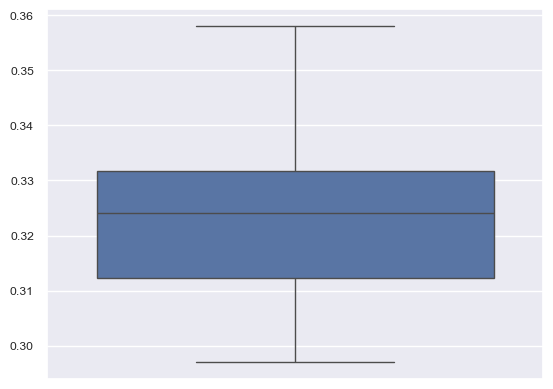

In [136]:
lda_prediction=[None]*50
lda_test_err=[None]*50

for i in range(50):
    lda_prediction[i] = lda.predict(X_test[i])
    lda_test_err[i] = sum(y_test[i]!=lda_prediction[i])/len(X_test[i])
sns.boxplot(lda_test_err)

In [137]:
lda_test_err = pd.DataFrame(lda_test_err, columns = ['Test Error'])
model=['LDA']*50
lda_test_err['Model']=model
lda_test_err.head()

,Test Error,Model
0,0.308,LDA
1,0.328,LDA
2,0.308,LDA
3,0.303,LDA
4,0.325,LDA


**B. QDA**

In [138]:
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train,y_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

<Axes: >

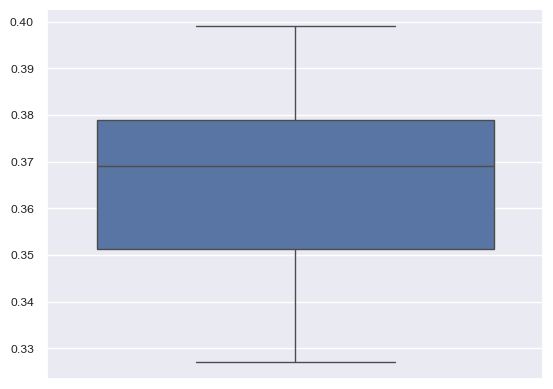

In [139]:
qda_prediction=[None]*50
qda_test_err=[None]*50

for i in range(50):
    qda_prediction[i] = qda.predict(X_test[i])
    qda_test_err[i] = sum(y_test[i]!=qda_prediction[i])/len(X_test[i])
sns.boxplot(qda_test_err)

In [140]:
qda_test_err = pd.DataFrame(qda_test_err, columns = ['Test Error'])
model=['QDA']*50
qda_test_err['Model']=model
qda_test_err.head()

,Test Error,Model
0,0.349,QDA
1,0.372,QDA
2,0.353,QDA
3,0.349,QDA
4,0.342,QDA


**C. NB**

In [141]:
NB = GaussianNB()
NB.fit(X_train,y_train)

GaussianNB()

<Axes: >

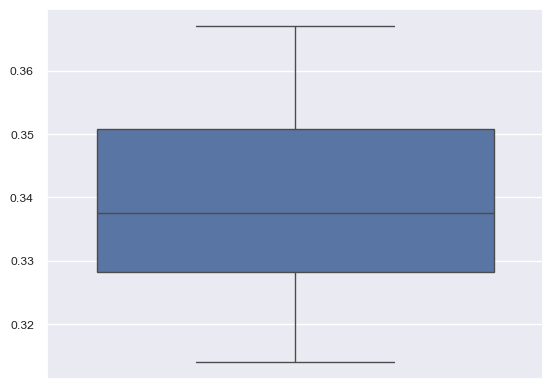

In [142]:
nb_prediction=[None]*50
nb_test_err=[None]*50

for i in range(50):
    nb_prediction[i] = NB.predict(X_test[i])
    nb_test_err[i] = sum(y_test[i]!=nb_prediction[i])/len(X_test[i])
sns.boxplot(nb_test_err)

In [143]:
nb_test_err = pd.DataFrame(nb_test_err, columns = ['Test Error'])
model=['NB']*50
nb_test_err['Model']=model
nb_test_err.head()

,Test Error,Model
0,0.324,NB
1,0.351,NB
2,0.319,NB
3,0.319,NB
4,0.343,NB


## (4) Tree-based: Decision Tree, Random Forest, Boosting

**A. Decision Tree**

In [144]:
parameters = {'criterion': ['gini', 'entropy', 'log_loss'],
             'min_samples_split': [2,5,10]}
dtreegs = GridSearchCV(DecisionTreeClassifier(random_state=1), parameters, n_jobs=1, cv=10)
dtreegs.fit(X_train, y_train)
dtreegs.best_params_

{'criterion': 'entropy', 'min_samples_split': 10}

<Axes: >

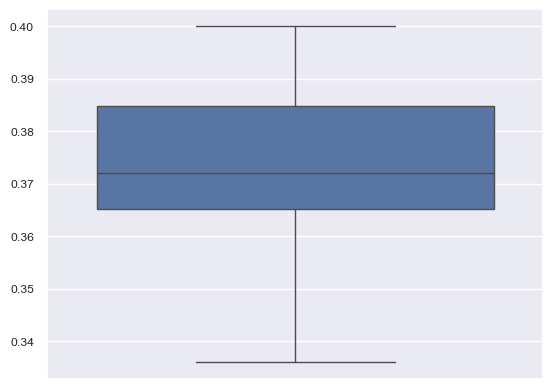

In [145]:
dtreegs_prediction=[None]*50
dtreegs_test_err=[None]*50

for i in range(50):
    dtreegs_prediction[i] = dtreegs.predict(X_test[i])
    dtreegs_test_err[i] = sum(y_test[i]!=dtreegs_prediction[i])/len(X_test[i])
sns.boxplot(dtreegs_test_err)

In [146]:
dtreegs_test_err = pd.DataFrame(dtreegs_test_err, columns = ['Test Error'])
model=['DTreeGS']*50
dtreegs_test_err['Model']=model
dtreegs_test_err.head()

,Test Error,Model
0,0.372,DTreeGS
1,0.385,DTreeGS
2,0.365,DTreeGS
3,0.336,DTreeGS
4,0.355,DTreeGS


**B. Bagging**

<Axes: >

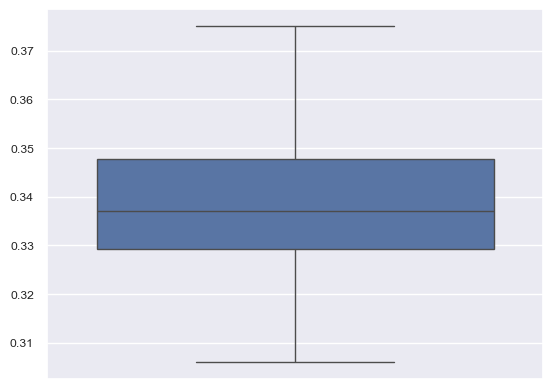

In [147]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(random_state=1)
bagging.fit(X_train,y_train)

bagging_prediction=[None]*50
bagging_test_err=[None]*50

for i in range(50):
    bagging_prediction[i] = bagging.predict(X_test[i])
    bagging_test_err[i] = sum(y_test[i]!=bagging_prediction[i])/len(X_test[i])
sns.boxplot(bagging_test_err)

In [148]:
bagging_test_err = pd.DataFrame(bagging_test_err, columns = ['Test Error'])
model=['Bagging']*50
bagging_test_err['Model']=model
bagging_test_err.head()

,Test Error,Model
0,0.329,Bagging
1,0.338,Bagging
2,0.322,Bagging
3,0.306,Bagging
4,0.331,Bagging


**C. Random Forest**

In [149]:
parameters = {'n_estimators': [5, 10, 100, 500],
             'criterion': ['gini', 'entropy', 'log_loss'],
             'min_samples_split': [2,5,10]}

rfcgs = GridSearchCV(RandomForestClassifier(random_state=1), parameters, n_jobs=1, cv=10)
rfcgs.fit(X_train, y_train)
rfcgs.best_params_

{'criterion': 'entropy', 'min_samples_split': 5, 'n_estimators': 500}

<Axes: >

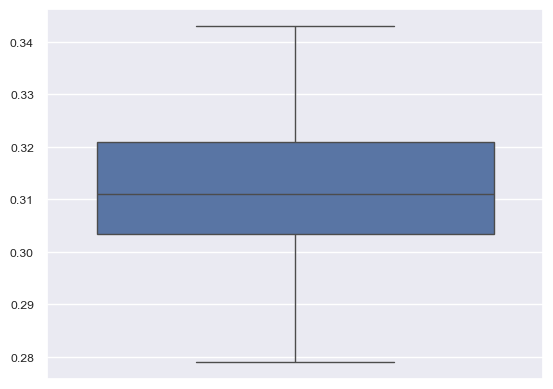

In [150]:
rfcgs_prediction=[None]*50
rfcgs_test_err=[None]*50

for i in range(50):
    rfcgs_prediction[i] = rfcgs.predict(X_test[i])
    rfcgs_test_err[i] = sum(y_test[i]!=rfcgs_prediction[i])/len(X_test[i])
sns.boxplot(rfcgs_test_err)

In [151]:
rfcgs_test_err = pd.DataFrame(rfcgs_test_err, columns = ['Test Error'])
model=['RFCGS']*50
rfcgs_test_err['Model']=model
rfcgs_test_err.head()

,Test Error,Model
0,0.312,RFCGS
1,0.303,RFCGS
2,0.301,RFCGS
3,0.300,RFCGS
4,0.309,RFCGS


**D. Gradient Boosting Classifier**

In [152]:
parameters = {'n_estimators': [5, 10, 100],
             'min_samples_split': [2,5,10],
             'learning_rate': [0.001,0.01, 0.1, 0.5, 0.9],
              'max_depth': [1,2,3,5]
             }

gbcgs = GridSearchCV(GradientBoostingClassifier(random_state=1), parameters, n_jobs=1, cv=10)
gbcgs.fit(X_train, y_train)
gbcgs.best_params_


{'learning_rate': 0.1,
 'max_depth': 3,
 'min_samples_split': 10,
 'n_estimators': 100}

<Axes: >

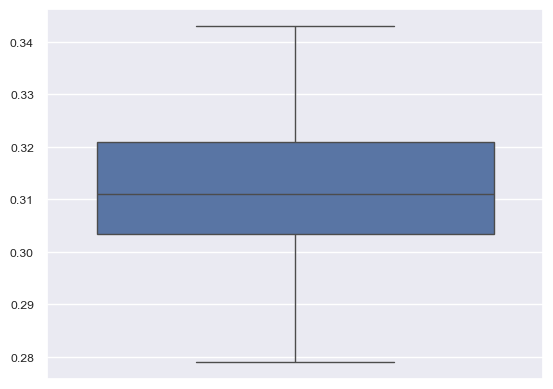

In [153]:
gbcgs_prediction=[None]*50
gbcgs_test_err=[None]*50

for i in range(50):
    gbcgs_prediction[i] = rfcgs.predict(X_test[i])
    gbcgs_test_err[i] = sum(y_test[i]!=rfcgs_prediction[i])/len(X_test[i])

sns.boxplot(gbcgs_test_err)

In [154]:
gbcgs_test_err = pd.DataFrame(gbcgs_test_err, columns = ['Test Error'])
model=['GBCGS']*50
gbcgs_test_err['Model']=model
gbcgs_test_err.head()

,Test Error,Model
0,0.312,GBCGS
1,0.303,GBCGS
2,0.301,GBCGS
3,0.300,GBCGS
4,0.309,GBCGS


## (5) SVM

In [155]:
parameters = {'C': [0.1,1, 10, 100, 1000],
              'gamma': [1,0.1,0.01,0.001,0.0001],
              'kernel': ['rbf'],
             'decision_function_shape': ['ovo']}

svmgs = GridSearchCV(svm.SVC(random_state=1), parameters, n_jobs=1, cv=10)
svmgs.fit(X_train, y_train)
svmgs.best_params_

{'C': 10, 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'rbf'}

<Axes: >

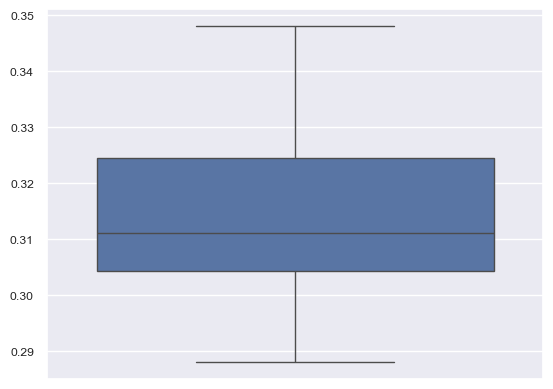

In [156]:
svmgs_prediction=[None]*50
svmgs_test_err=[None]*50

for i in range(50):
    svmgs_prediction[i] = svmgs.predict(X_test[i])
    svmgs_test_err[i] = sum(y_test[i]!=svmgs_prediction[i])/len(X_test[i])

sns.boxplot(svmgs_test_err)

In [157]:
svmgs_test_err = pd.DataFrame(svmgs_test_err, columns = ['Test Error'])
model=['SVMGS']*50
svmgs_test_err['Model']=model
svmgs_test_err.head()

,Test Error,Model
0,0.309,SVMGS
1,0.314,SVMGS
2,0.298,SVMGS
3,0.288,SVMGS
4,0.304,SVMGS


## (6) ANN

**A. Data Pre-processing**

In [158]:
# Separate categorical from continuous columns
cat_cols = ['sex', 'hear_left', 'hear_right']
y_col = [Y_col_name]
cont_cols = [col for col in X_train.columns if col not in cat_cols + y_col]

**B. Set an embedding size**

In [159]:
# This will set embedding sizes for sex,hear_left, hear_right, urine_protein
cat_szs = [X_train[col].nunique() for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1), (2, 1), (2, 1)]

**C. Define Model class**

In [160]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))

        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)

        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

**D. Declare model and define loss function and optimizer**

In [161]:
# Define a function to convert dataframe to category tensor, continues tensor and Y tensor
# This function can be used in both training and test
def dl_data_to_tensor(dl_data):
    # Convert our four categorical columns to category dtypes.
    for cat in cat_cols:
        dl_data[cat] = dl_data[cat].astype('category')
    # Combine the four categorical columns into one input array
    cats = np.stack([dl_data[col].cat.codes.values for col in cat_cols], 1)
    # Convert categorical variables to a tensor
    cats = torch.tensor(cats, dtype=torch.int64)
    # Convert continuous variables to a tensor
    conts = np.stack([dl_data[col].values for col in cont_cols], 1)
    conts = torch.tensor(conts, dtype=torch.float)
    # Convert labels to a tensor
    y = torch.tensor(dl_data[y_col].values).flatten()
    return cats, conts, y

In [162]:
cats, conts, y = dl_data_to_tensor(pd.concat([X_train, y_train], axis=1))
print(cats[:5])
print(conts[:5])
#print(y[:5])

tensor([[0, 1, 1],
        [0, 1, 1],
        [0, 1, 1],
        [0, 1, 1],
        [1, 1, 1]])
tensor([[ 1.6814e-01,  1.3745e+00,  5.3667e-01, -1.8816e-02, -1.4402e-01,
         -4.2895e-01, -1.1987e+00, -1.5222e+00, -2.2438e-01,  3.2192e-01,
          2.3577e-01,  5.2905e-01, -5.3953e-01,  5.4899e-01,  8.2235e-02,
         -2.1239e-01, -1.4276e-01, -3.9936e-01],
        [-5.3702e-01,  8.3585e-01,  1.3358e+00,  1.9621e+00,  1.4583e-01,
         -4.2895e-01,  5.2031e-01,  1.4103e+00, -4.3116e-01, -1.4369e-01,
         -4.0236e-01,  3.6165e-01, -6.0803e-01, -5.8675e-01, -1.2586e-01,
         -2.5495e-01,  8.5297e-02, -5.1835e-01],
        [ 1.2259e+00, -2.4137e-01, -2.6242e-01,  1.8970e-01,  1.4583e-01,
          1.5325e-01,  3.8972e-02, -4.0985e-01, -2.6573e-01,  1.9259e-01,
          2.9378e-01,  5.0115e-01, -8.4287e-01,  8.0137e-01,  8.2235e-02,
          4.2797e-04,  4.7288e-02,  3.6934e-02],
        [-5.3702e-01,  1.3745e+00,  2.5344e+00,  1.0238e+00,  7.2555e-01,
          7.3545e

In [163]:
# Note for ANN parameters
# To save time, I use the 3rd generated response smoker_drinker + sample 1 to do best parameter selection by hand
# The parameter that gives the smallest test rate is 'layer + neuron' = [500, 400, 200, 100], p=0.5, epoch = 300
# The selected best parameter is applied to train all the ANN models for drinker and smoker. 

torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], Y_class_num, [500, 400, 200,100], p=0.5) # out_sz=2

In [164]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**E. Train the model**

epoch:   1  loss: 1.26457572
Duration: 1 seconds
epoch:  26  loss: 0.83444172
Duration: 7 seconds
epoch:  51  loss: 0.78789723
Duration: 15 seconds
epoch:  76  loss: 0.75042260
Duration: 23 seconds
epoch: 101  loss: 0.73024684
Duration: 36 seconds
epoch: 126  loss: 0.70159686
Duration: 45 seconds
epoch: 151  loss: 0.68363297
Duration: 52 seconds
epoch: 176  loss: 0.67780954
Duration: 58 seconds
epoch: 201  loss: 0.67286736
Duration: 64 seconds
epoch: 226  loss: 0.66772532
Duration: 72 seconds
epoch: 251  loss: 0.65421653
Duration: 78 seconds
epoch: 276  loss: 0.64972889
Duration: 84 seconds
epoch: 300  loss: 0.64497191
Duration: 91 seconds


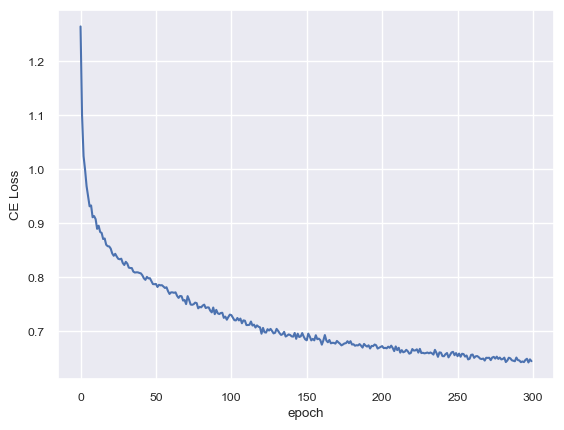

In [165]:
import time
start_time = time.time()

epochs = 300  # how many iterations
losses = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(cats, conts)
    loss = criterion(y_pred, y)
    losses.append(loss.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')
        print(f'Duration: {time.time() - start_time:.0f} seconds') # print the time elapsedi

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'Duration: {time.time() - start_time:.0f} seconds') # print the time elapsedi
plt.plot(range(epochs), losses)
plt.ylabel('CE Loss')
plt.xlabel('epoch');

**F. Evaluate ANN model with 50 set of test data**

In [166]:
ann_prediction=[None]*50
ann_test_err=[None]*50

with torch.no_grad():
    for i in range(50):
        ann_test = pd.concat([X_test[i], y_test[i]], axis=1)
        cats_test, conts_test, y_tensor = dl_data_to_tensor(ann_test)
        ann_test_pred = model(cats_test, conts_test)
        loss = criterion(ann_test_pred, y_tensor)
        ann_prediction[i] = ann_test_pred.argmax(dim=1).numpy()
        ann_test_err[i] = sum(y_test[i].to_numpy()!=ann_prediction[i])/len(X_test[i])

<Axes: >

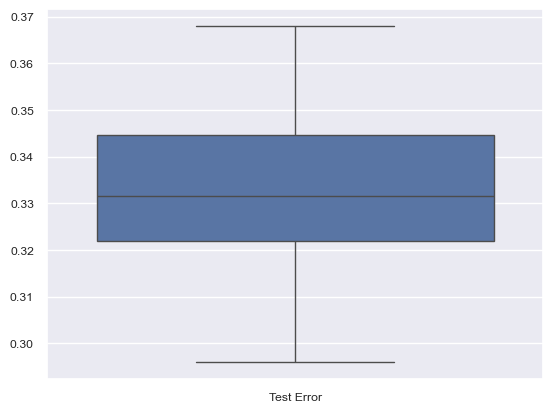

In [167]:
ann_test_err = pd.DataFrame(ann_test_err, columns = ['Test Error'])
model=['ANN']*50
ann_test_err['Model']=model
sns.boxplot(ann_test_err)

## 7. Model Checking & Select Models: Sample Data 10k

<Axes: xlabel='Model', ylabel='Test Error'>

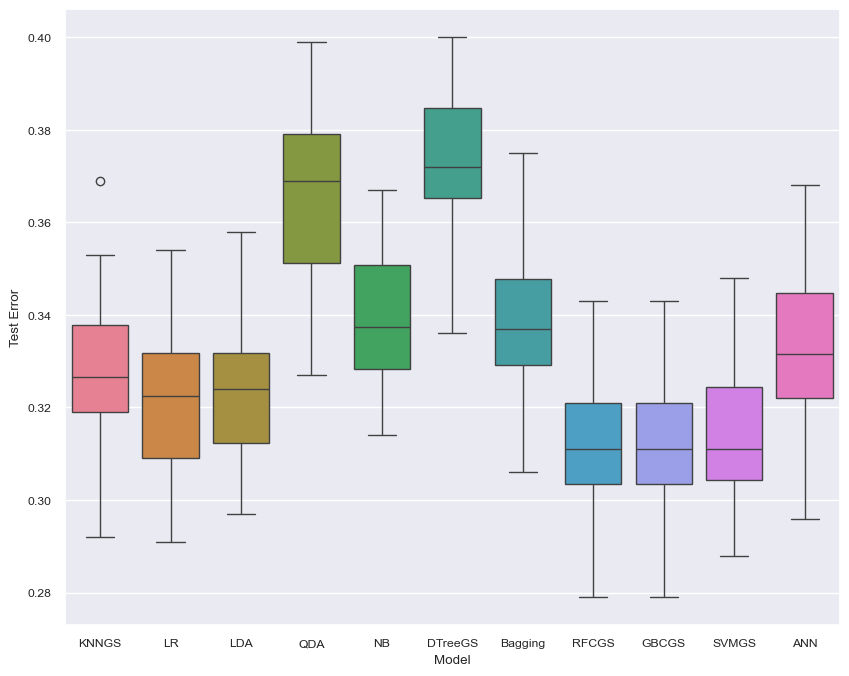

In [170]:
test_error_10k = pd.concat([knngs_test_err, lr_test_err, lda_test_err, qda_test_err,nb_test_err,
                            dtreegs_test_err, bagging_test_err, rfcgs_test_err, gbcgs_test_err, svmgs_test_err, ann_test_err], axis=0)

plt.subplots(figsize =(10,8))
sns.boxplot(data=test_error_10k, y='Test Error', x="Model", hue="Model")

In [171]:
test_error_10k.groupby(['Model']).mean()

,Test Error
Model,
ANN,0.33232
Bagging,0.33836
DTreeGS,0.37252
GBCGS,0.31188
KNNGS,0.32846
LDA,0.32328
LR,0.32144
NB,0.33806
QDA,0.36574


## 8. Sample and Split: 2st Trial

**Sample 2: random sample 100k observations as training set; random sample 50 test sets, each of which has 5,000 observations**

In [83]:
# Set seed to make the results reproducible
np.random.seed(1000)

# Get index for 100,000 training data points out of 991,263 observations
training_index = np.random.choice(range(991263), 100000)

In [84]:
# Sample the training data set to contain 100,000 observations for faster propotype
training = data.iloc[training_index]
X_train = training.iloc[:,0:-1]
y_train = training[Y_col_name]

In [85]:
# Randomly sample 50 test data sets from the rest 990,263 observations. Each contains 5,000 observations
test_pool = data.drop(index=training_index)
X_test = [None]*50
y_test = [None]*50

for i in range(50):
    testdata=test_pool.sample(n=5000, random_state=i)
    X_test[i] = testdata.iloc[:,0:-1]
    y_test[i] = testdata[Y_col_name]

In [86]:
y_train.groupby(y_train).count()

smoker
0    60786
1    17603
2    21611
Name: smoker, dtype: int64

## 9. Fit Classification Models: Sample Data 2

## (1) KNN

In [87]:
parameters = {'n_neighbors': [1, 5, 10, 50, 100, 500, 1000],
              'weights': ['uniform', 'distance']}

knngs = GridSearchCV(neighbors.KNeighborsClassifier(), parameters, cv=10,
                     scoring='accuracy', return_train_score=False,verbose=1,error_score='raise')

# fitting the model for grid search
knngs.fit(X_train, y_train)
knngs.best_params_

Fitting 10 folds for each of 14 candidates, totalling 140 fits


{'n_neighbors': 100, 'weights': 'distance'}

<Axes: >

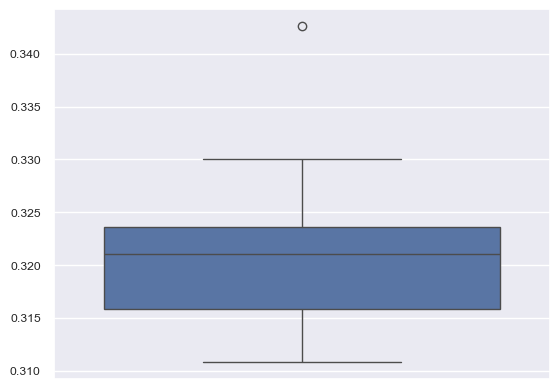

In [88]:
knngs_prediction=[None]*50
knngs_test_err=[None]*50

for i in range(50):
    knngs_prediction[i] = knngs.predict(X_test[i])
    knngs_test_err[i] = sum(y_test[i]!=knngs_prediction[i])/len(X_test[i])
sns.boxplot(knngs_test_err)

In [89]:
knngs_test_err = pd.DataFrame(knngs_test_err, columns = ['Test Error'])
model=['KNNGS']*50
knngs_test_err['Model']=model
knngs_test_err.head()

,Test Error,Model
0,0.3198,KNNGS
1,0.3120,KNNGS
2,0.3216,KNNGS
3,0.3178,KNNGS
4,0.3224,KNNGS


## (2) Logistic Regression

In [90]:
lr = LogisticRegression(penalty='l2',max_iter=200,solver='newton-cg')
lr.fit(X_train,y_train)

LogisticRegression(max_iter=200, solver='newton-cg')

<Axes: >

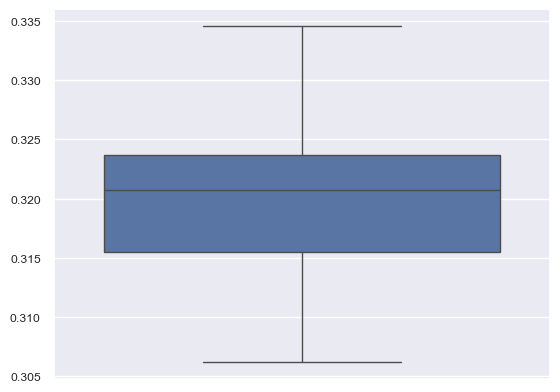

In [91]:
lr_prediction=[None]*50
lr_test_err=[None]*50

for i in range(50):
    lr_prediction[i] = lr.predict(X_test[i])
    lr_test_err[i] = sum(y_test[i]!=lr_prediction[i])/len(X_test[i])
sns.boxplot(lr_test_err)

In [92]:
lr_test_err = pd.DataFrame(lr_test_err, columns = ['Test Error'])
model=['LR']*50
lr_test_err['Model']=model
lr_test_err.head()

,Test Error,Model
0,0.3230,LR
1,0.3176,LR
2,0.3194,LR
3,0.3186,LR
4,0.3224,LR


## (3) LDA, QDA, NB

**A. LDA**

In [93]:
lda = LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis(store_covariance=True)

<Axes: >

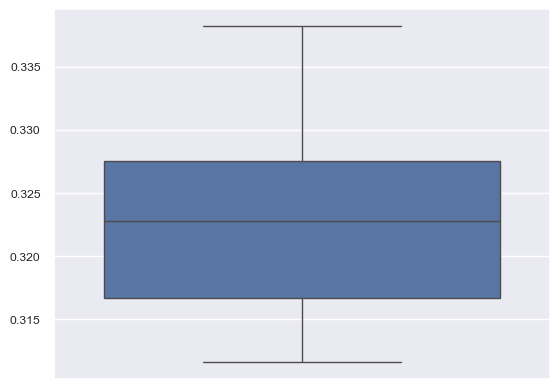

In [94]:
lda_prediction=[None]*50
lda_test_err=[None]*50

for i in range(50):
    lda_prediction[i] = lda.predict(X_test[i])
    lda_test_err[i] = sum(y_test[i]!=lda_prediction[i])/len(X_test[i])
sns.boxplot(lda_test_err)

In [95]:
lda_test_err = pd.DataFrame(lda_test_err, columns = ['Test Error'])
model=['LDA']*50
lda_test_err['Model']=model
lda_test_err.head()

,Test Error,Model
0,0.3248,LDA
1,0.3206,LDA
2,0.3210,LDA
3,0.3176,LDA
4,0.3278,LDA


**B. QDA**

In [96]:
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train,y_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

<Axes: >

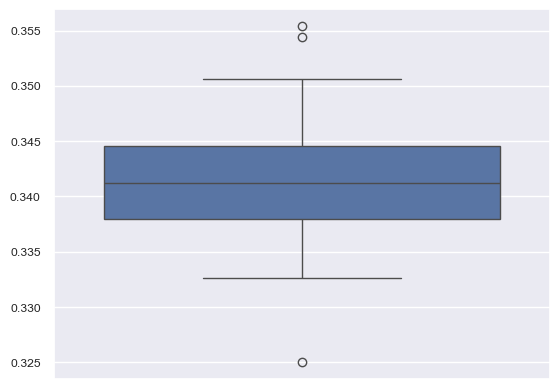

In [97]:
qda_prediction=[None]*50
qda_test_err=[None]*50

for i in range(50):
    qda_prediction[i] = qda.predict(X_test[i])
    qda_test_err[i] = sum(y_test[i]!=qda_prediction[i])/len(X_test[i])
sns.boxplot(qda_test_err)

In [98]:
qda_test_err = pd.DataFrame(qda_test_err, columns = ['Test Error'])
model=['QDA']*50
qda_test_err['Model']=model
qda_test_err.head()

,Test Error,Model
0,0.3434,QDA
1,0.3412,QDA
2,0.3434,QDA
3,0.3358,QDA
4,0.3412,QDA


**C. NB**

In [99]:
NB = GaussianNB()
NB.fit(X_train,y_train)

GaussianNB()

<Axes: >

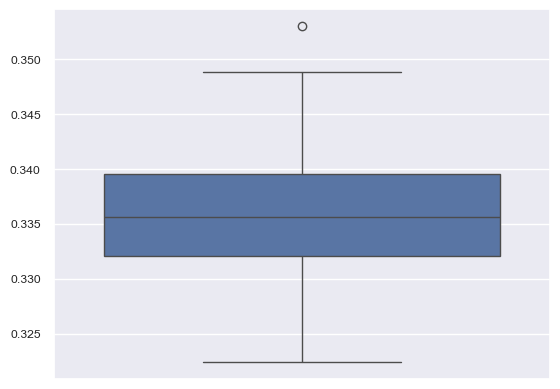

In [100]:
nb_prediction=[None]*50
nb_test_err=[None]*50

for i in range(50):
    nb_prediction[i] = NB.predict(X_test[i])
    nb_test_err[i] = sum(y_test[i]!=nb_prediction[i])/len(X_test[i])
sns.boxplot(nb_test_err)

In [101]:
nb_test_err = pd.DataFrame(nb_test_err, columns = ['Test Error'])
model=['NB']*50
nb_test_err['Model']=model
nb_test_err.head()

,Test Error,Model
0,0.3402,NB
1,0.3326,NB
2,0.3320,NB
3,0.3280,NB
4,0.3382,NB


## (4) Tree-based: Decision Tree, Bagging, Random Forest

**A. Decision Tree**

In [102]:
parameters = {'criterion': ['gini', 'entropy', 'log_loss'],
             'min_samples_split': [2,5,10]}
dtreegs = GridSearchCV(DecisionTreeClassifier(random_state=1), parameters, n_jobs=1, cv=10)
dtreegs.fit(X_train, y_train)
dtreegs.best_params_

{'criterion': 'gini', 'min_samples_split': 10}

<Axes: >

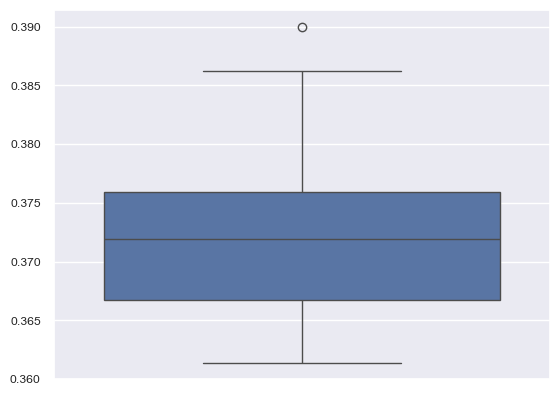

In [103]:
dtreegs_prediction=[None]*50
dtreegs_test_err=[None]*50

for i in range(50):
    dtreegs_prediction[i] = dtreegs.predict(X_test[i])
    dtreegs_test_err[i] = sum(y_test[i]!=dtreegs_prediction[i])/len(X_test[i])
sns.boxplot(dtreegs_test_err)

In [122]:
dtreegs_test_err = pd.DataFrame(dtreegs_test_err, columns = ['Test Error'])
model=['DTreeGS']*50
dtreegs_test_err['Model']=model
dtreegs_test_err.head()

,Test Error,Model
0,0.3774,DTreeGS
1,0.3784,DTreeGS
2,0.3700,DTreeGS
3,0.3664,DTreeGS
4,0.3816,DTreeGS


**B. Bagging**

<Axes: >

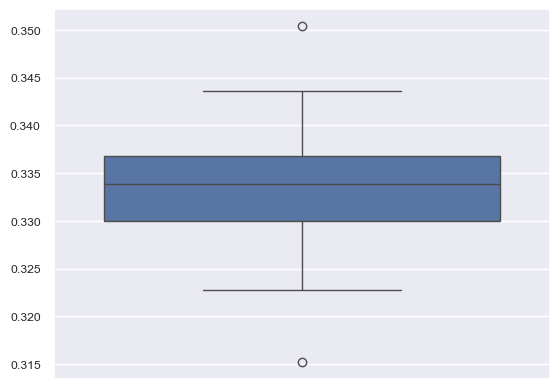

In [105]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(random_state=1)
bagging.fit(X_train,y_train)

bagging_prediction=[None]*50
bagging_test_err=[None]*50

for i in range(50):
    bagging_prediction[i] = bagging.predict(X_test[i])
    bagging_test_err[i] = sum(y_test[i]!=bagging_prediction[i])/len(X_test[i])
sns.boxplot(bagging_test_err)

In [106]:
bagging_test_err = pd.DataFrame(bagging_test_err, columns = ['Test Error'])
model=['Bagging']*50
bagging_test_err['Model']=model
bagging_test_err.head()

,Test Error,Model
0,0.3400,Bagging
1,0.3356,Bagging
2,0.3352,Bagging
3,0.3320,Bagging
4,0.3378,Bagging


**C. Random Forest**

In [107]:
parameters = {'n_estimators': [5, 10, 100, 500],
             'criterion': ['gini', 'entropy', 'log_loss'],
             'min_samples_split': [2,5,10]}

rfcgs = GridSearchCV(RandomForestClassifier(random_state=1), parameters, n_jobs=1, cv=10)
rfcgs.fit(X_train, y_train)
rfcgs.best_params_

{'criterion': 'gini', 'min_samples_split': 5, 'n_estimators': 500}

<Axes: >

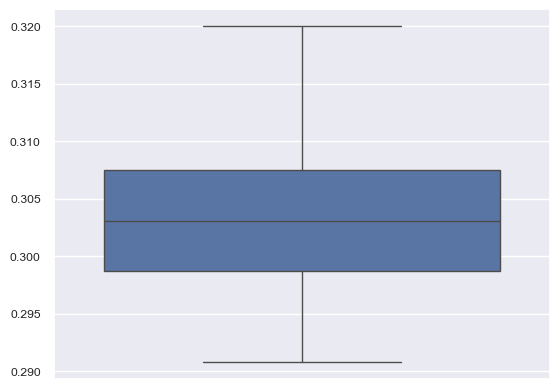

In [108]:
rfcgs_prediction=[None]*50
rfcgs_test_err=[None]*50

for i in range(50):
    rfcgs_prediction[i] = rfcgs.predict(X_test[i])
    rfcgs_test_err[i] = sum(y_test[i]!=rfcgs_prediction[i])/len(X_test[i])
sns.boxplot(rfcgs_test_err)

In [109]:
rfcgs_test_err = pd.DataFrame(rfcgs_test_err, columns = ['Test Error'])
model=['RFCGS']*50
rfcgs_test_err['Model']=model
rfcgs_test_err.head()

,Test Error,Model
0,0.3096,RFCGS
1,0.3042,RFCGS
2,0.3022,RFCGS
3,0.2976,RFCGS
4,0.3064,RFCGS


## (6) ANN

**A. Data Pre-processing**

In [110]:
# Separate categorical from continuous columns
cat_cols = ['sex', 'hear_left', 'hear_right']
y_col = [Y_col_name]
cont_cols = [col for col in X_train.columns if col not in cat_cols + y_col]

**B. Set an embedding size**

In [111]:
# This will set embedding sizes for sex,hear_left, hear_right, urine_protein
cat_szs = [X_train[col].nunique() for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1), (2, 1), (2, 1)]

**C. Define Model class**

In [112]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))

        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)

        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

**D. Declare model and define loss function and optimizer**

In [113]:
# Define a function to convert dataframe to category tensor, continues tensor and Y tensor
# This function can be used in both training and test
def dl_data_to_tensor(dl_data):
    # Convert our four categorical columns to category dtypes.
    for cat in cat_cols:
        dl_data[cat] = dl_data[cat].astype('category')
    # Combine the four categorical columns into one input array
    cats = np.stack([dl_data[col].cat.codes.values for col in cat_cols], 1)
    # Convert categorical variables to a tensor
    cats = torch.tensor(cats, dtype=torch.int64)
    # Convert continuous variables to a tensor
    conts = np.stack([dl_data[col].values for col in cont_cols], 1)
    conts = torch.tensor(conts, dtype=torch.float)
    # Convert labels to a tensor
    y = torch.tensor(dl_data[y_col].values).flatten()
    return cats, conts, y

In [114]:
cats, conts, y = dl_data_to_tensor(pd.concat([X_train, y_train], axis=1))
print(cats[:5])
print(conts[:5])
print(y[:5])

tensor([[0, 1, 1],
        [0, 1, 1],
        [0, 1, 1],
        [0, 1, 1],
        [1, 1, 1]])
tensor([[ 1.6814e-01,  1.3745e+00,  5.3667e-01, -1.8816e-02, -1.4402e-01,
         -4.2895e-01, -1.1987e+00, -1.5222e+00, -2.2438e-01,  3.2192e-01,
          2.3577e-01,  5.2905e-01, -5.3953e-01,  5.4899e-01,  8.2235e-02,
         -2.1239e-01, -1.4276e-01, -3.9936e-01],
        [-5.3702e-01,  8.3585e-01,  1.3358e+00,  1.9621e+00,  1.4583e-01,
         -4.2895e-01,  5.2031e-01,  1.4103e+00, -4.3116e-01, -1.4369e-01,
         -4.0236e-01,  3.6165e-01, -6.0803e-01, -5.8675e-01, -1.2586e-01,
         -2.5495e-01,  8.5297e-02, -5.1835e-01],
        [ 1.2259e+00, -2.4137e-01, -2.6242e-01,  1.8970e-01,  1.4583e-01,
          1.5325e-01,  3.8972e-02, -4.0985e-01, -2.6573e-01,  1.9259e-01,
          2.9378e-01,  5.0115e-01, -8.4287e-01,  8.0137e-01,  8.2235e-02,
          4.2797e-04,  4.7288e-02,  3.6934e-02],
        [-5.3702e-01,  1.3745e+00,  2.5344e+00,  1.0238e+00,  7.2555e-01,
          7.3545e

In [115]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], Y_class_num, [500, 400, 200,100], p=0.5) # out_sz=2

In [116]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**E. Train the model**

epoch:   1  loss: 1.25719607
Duration: 3 seconds
epoch:  26  loss: 0.83404076
Duration: 70 seconds
epoch:  51  loss: 0.79007673
Duration: 137 seconds
epoch:  76  loss: 0.75237304
Duration: 204 seconds
epoch: 101  loss: 0.71892297
Duration: 275 seconds
epoch: 126  loss: 0.69760507
Duration: 342 seconds
epoch: 151  loss: 0.69296229
Duration: 409 seconds
epoch: 176  loss: 0.69052625
Duration: 476 seconds
epoch: 201  loss: 0.68635142
Duration: 544 seconds
epoch: 226  loss: 0.68047720
Duration: 612 seconds
epoch: 251  loss: 0.68100971
Duration: 680 seconds
epoch: 276  loss: 0.67576736
Duration: 753 seconds
epoch: 300  loss: 0.67503780
Duration: 819 seconds


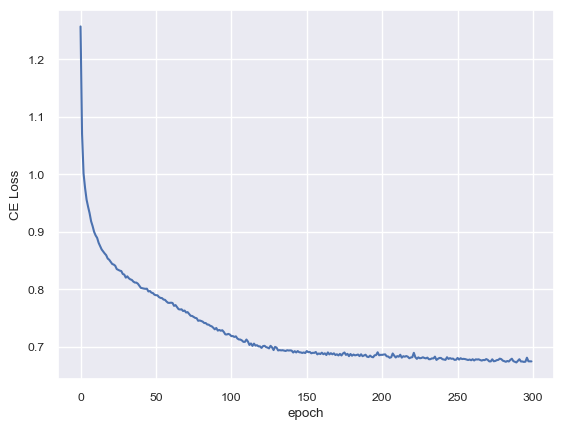

In [117]:
import time
start_time = time.time()

epochs = 300  # how many iterations
losses = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(cats, conts)
    loss = criterion(y_pred, y)
    losses.append(loss.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')
        print(f'Duration: {time.time() - start_time:.0f} seconds') # print the time elapsedi

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'Duration: {time.time() - start_time:.0f} seconds') # print the time elapsedi
plt.plot(range(epochs), losses)
plt.ylabel('CE Loss')
plt.xlabel('epoch');

**F. Evaluate ANN model with 50 set of test data**

In [118]:
ann_prediction=[None]*50
ann_test_err=[None]*50

with torch.no_grad():
    for i in range(50):
        ann_test = pd.concat([X_test[i], y_test[i]], axis=1)
        cats_test, conts_test, y_tensor = dl_data_to_tensor(ann_test)
        ann_test_pred = model(cats_test, conts_test)
        loss = criterion(ann_test_pred, y_tensor)
        ann_prediction[i] = ann_test_pred.argmax(dim=1).numpy()
        ann_test_err[i] = sum(y_test[i].to_numpy()!=ann_prediction[i])/len(X_test[i])

<Axes: >

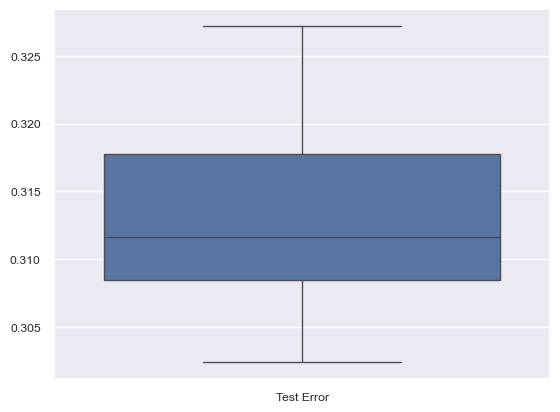

In [119]:
ann_test_err = pd.DataFrame(ann_test_err, columns = ['Test Error'])
model=['ANN']*50
ann_test_err['Model']=model
sns.boxplot(ann_test_err)

## 10. Model Checking & Select Models: Sample Data 2

<Axes: xlabel='Model', ylabel='Test Error'>

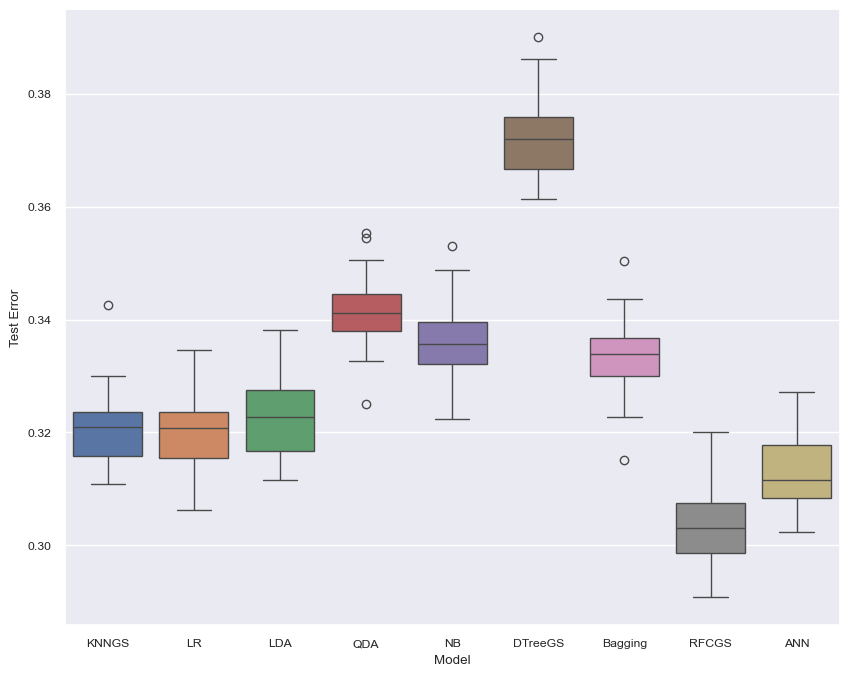

In [123]:
test_error_100k = pd.concat([knngs_test_err, lr_test_err, lda_test_err, qda_test_err,nb_test_err,
                             dtreegs_test_err, bagging_test_err, rfcgs_test_err, ann_test_err], axis=0)

plt.subplots(figsize =(10,8))
sns.boxplot(data=test_error_100k, y='Test Error', x="Model", hue="Model")

In [124]:
test_error_100k.groupby(['Model']).mean()

,Test Error
Model,
ANN,0.312852
Bagging,0.333416
DTreeGS,0.372404
KNNGS,0.320596
LDA,0.322824
LR,0.319852
NB,0.335796
QDA,0.341740
RFCGS,0.303268


## Final: Apply the selected models & best parameters to the whole dataset

**Training & Test split**

In [172]:
X=data.iloc[:,0:-1]
y=data[Y_col_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [173]:
X_train.shape

(693884, 21)

In [174]:
X_test.shape

(297379, 21)

**(1) KNN**

In [175]:
start_time = time.time()

knnmodel = neighbors.KNeighborsClassifier(n_neighbors=100, weights='distance')
knnmodel.fit(X_train, y_train)
knn_predict = knnmodel.predict(X_test)

print(classification_report(y_test,knn_predict))
print(confusion_matrix(y_test,knn_predict))
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsedi

              precision    recall  f1-score   support

           0       0.82      0.82      0.82    180388
           1       0.44      0.37      0.40     52822
           2       0.50      0.56      0.52     64169

    accuracy                           0.69    297379
   macro avg       0.58      0.58      0.58    297379
weighted avg       0.68      0.69      0.68    297379

[[148533  13752  18103]
 [ 14988  19491  18343]
 [ 16976  11461  35732]]

Duration: 190 seconds


**(2) Logistic Regression**

In [176]:
start_time = time.time()

lrmodel = LogisticRegression(penalty='l2',max_iter=200,solver='newton-cg')
lrmodel.fit(X_train,y_train)
lrmodel_predict = lrmodel.predict(X_test)

print(classification_report(y_test,lrmodel_predict))
print(confusion_matrix(y_test,lrmodel_predict))
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsedi

              precision    recall  f1-score   support

           0       0.83      0.80      0.81    180388
           1       0.44      0.34      0.39     52822
           2       0.48      0.63      0.55     64169

    accuracy                           0.68    297379
   macro avg       0.58      0.59      0.58    297379
weighted avg       0.69      0.68      0.68    297379

[[143418  13373  23597]
 [ 14952  18110  19760]
 [ 14209   9651  40309]]

Duration: 21 seconds


**(3) LDA**

In [177]:
start_time = time.time()

ldamodel = LinearDiscriminantAnalysis(store_covariance=True)
ldamodel.fit(X_train,y_train)
ldamodel_predict=ldamodel.predict(X_test)

print(classification_report(y_test,ldamodel_predict))
print(confusion_matrix(y_test,ldamodel_predict))
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsedi

              precision    recall  f1-score   support

           0       0.94      0.73      0.82    180388
           1       0.42      0.50      0.46     52822
           2       0.46      0.69      0.55     64169

    accuracy                           0.68    297379
   macro avg       0.61      0.64      0.61    297379
weighted avg       0.74      0.68      0.70    297379

[[131038  21178  28172]
 [  3333  26288  23201]
 [  4983  15097  44089]]

Duration: 3 seconds


**(4) Random Forest**

In [178]:
start_time = time.time()

rfcmodel=RandomForestClassifier(n_estimators=500, criterion='gini', min_samples_split=5, random_state=1)
rfcmodel.fit(X_train, y_train)
rfcmodel_prediction = rfcmodel.predict(X_test)

print(classification_report(y_test,rfcmodel_prediction))
print(confusion_matrix(y_test,rfcmodel_prediction))
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsedi

              precision    recall  f1-score   support

           0       0.84      0.82      0.83    180388
           1       0.45      0.39      0.41     52822
           2       0.51      0.60      0.55     64169

    accuracy                           0.70    297379
   macro avg       0.60      0.60      0.60    297379
weighted avg       0.70      0.70      0.70    297379

[[148487  14176  17725]
 [ 13491  20343  18988]
 [ 14507  10968  38694]]

Duration: 1140 seconds


**(5) Gradient Boosting Classifier**

In [179]:
start_time = time.time()

gbcmodel=GradientBoostingClassifier(n_estimators=100, min_samples_split=10, learning_rate=0.1, max_depth=3, random_state=1)
gbcmodel.fit(X_train, y_train)
gbcmodel_prediction = gbcmodel.predict(X_test)

print(classification_report(y_test,gbcmodel_prediction))
print(confusion_matrix(y_test,gbcmodel_prediction))

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsedi

              precision    recall  f1-score   support

           0       0.84      0.82      0.83    180388
           1       0.45      0.40      0.42     52822
           2       0.51      0.60      0.55     64169

    accuracy                           0.70    297379
   macro avg       0.60      0.61      0.60    297379
weighted avg       0.70      0.70      0.70    297379

[[148402  14237  17749]
 [ 13258  20972  18592]
 [ 14394  11318  38457]]

Duration: 536 seconds


**(6) ANN**

**A. Data Pre-processing**

In [180]:
# Separate categorical from continuous columns
cat_cols = ['sex', 'hear_left', 'hear_right']
y_col = [Y_col_name]
cont_cols = [col for col in X_train.columns if col not in cat_cols + y_col]

**B. Set an embedding size**

In [181]:
# This will set embedding sizes for sex,hear_left, hear_right, urine_protein
cat_szs = [X_train[col].nunique() for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1), (2, 1), (2, 1)]

**C. Define Model class**

In [182]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))

        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)

        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

**D. Declare model and define loss function and optimizer**

In [183]:
cats, conts, y = dl_data_to_tensor(pd.concat([X_train, y_train], axis=1))
print(cats[:5])
print(conts[:5])
print(y[:5])

tensor([[0, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [0, 1, 1],
        [0, 1, 1]])
tensor([[-0.1844,  0.2972,  0.9362,  1.2323,  1.5951,  1.6087,  1.1392,  2.2193,
         -0.0176,  1.4342, -0.4604,  1.4776,  2.0438,  1.2430,  0.2903,  0.4261,
          1.2256,  1.0880],
        [-0.5370, -0.7800, -1.4610, -1.0614, -1.3035, -0.4289, -0.8549,  0.3991,
         -0.7207, -0.5058,  1.3960, -0.7264, -0.9212, -0.0189, -0.5421, -0.3826,
         -0.5989, -0.5382],
        [-0.8896, -0.2414, -0.6620, -0.6444, -0.1440, -0.7200, -1.2675, -1.1177,
         -0.6379, -0.1696,  0.1778,  0.1385, -0.7548, -0.9653, -0.5421, -0.5103,
         -0.5229, -0.3002],
        [ 0.8733,  0.8359,  0.9362, -0.4358, -1.0136, -1.0111, -1.1987, -2.0278,
          1.3058, -1.2301,  0.9899, -1.3681, -0.8429,  0.6752,  0.0822, -0.0421,
         -0.4468, -0.3002],
        [ 0.8733, -0.2414, -0.2624,  0.9195, -0.7237, -0.1378, -0.3048,  0.1969,
         -0.2657, -0.6352,  0.2358, -0.4474, -0.6570,  0.5490, 

In [184]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], Y_class_num, [500, 400, 200,100], p=0.5) # out_sz=2

In [185]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**E. Train the model**

epoch:   1  loss: 1.24924099
Duration: 28 seconds
epoch:  26  loss: 0.82593948
Duration: 408 seconds
epoch:  51  loss: 0.78030908
Duration: 803 seconds
epoch:  76  loss: 0.74014956
Duration: 1201 seconds
epoch: 101  loss: 0.70525712
Duration: 1788 seconds
epoch: 126  loss: 0.69300461
Duration: 2440 seconds
epoch: 151  loss: 0.68795717
Duration: 3082 seconds
epoch: 176  loss: 0.68228346
Duration: 3695 seconds
epoch: 201  loss: 0.67801344
Duration: 4343 seconds
epoch: 226  loss: 0.67577744
Duration: 4970 seconds
epoch: 251  loss: 0.67501205
Duration: 5611 seconds
epoch: 276  loss: 0.67269033
Duration: 6288 seconds
epoch: 300  loss: 0.67141771
Duration: 7005 seconds


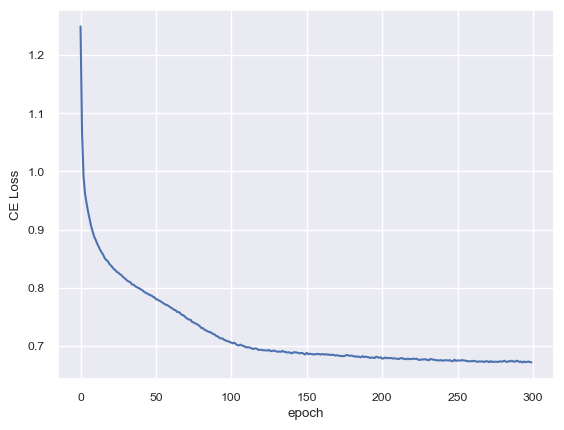

In [186]:
import time
start_time = time.time()

epochs = 300  # how many iterations
losses = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(cats, conts)
    loss = criterion(y_pred, y)
    losses.append(loss.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')
        print(f'Duration: {time.time() - start_time:.0f} seconds') # print the time elapsedi

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'Duration: {time.time() - start_time:.0f} seconds') # print the time elapsedi
plt.plot(range(epochs), losses)
plt.ylabel('CE Loss')
plt.xlabel('epoch');

**F. Evaluate ANN model with test data**

In [187]:
start_time = time.time()
with torch.no_grad():
    ann_test = pd.concat([X_test, y_test], axis=1)
    cats_test, conts_test, y_tensor = dl_data_to_tensor(ann_test)
    ann_test_pred = model(cats_test, conts_test)
    ann_prediction = ann_test_pred.argmax(dim=1).numpy()


print(classification_report(y_test,ann_prediction))
print(confusion_matrix(y_test,ann_prediction))

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsedi

              precision    recall  f1-score   support

           0       0.80      0.85      0.82    180388
           1       0.44      0.32      0.37     52822
           2       0.52      0.55      0.53     64169

    accuracy                           0.69    297379
   macro avg       0.59      0.57      0.58    297379
weighted avg       0.68      0.69      0.68    297379

[[152933  11787  15668]
 [ 18704  16994  17124]
 [ 19219   9797  35153]]

Duration: 4 seconds
